In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import KFold

In [ ]:
RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
!wget https://www.dropbox.com/s/pjkn1icctxrc2en/Mask_Data.zip?dl=0

--2022-06-22 18:27:32--  https://www.dropbox.com/s/pjkn1icctxrc2en/Mask_Data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pjkn1icctxrc2en/Mask_Data.zip [following]
--2022-06-22 18:27:33--  https://www.dropbox.com/s/raw/pjkn1icctxrc2en/Mask_Data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc5d52f704d708cd626c9fcc887.dl.dropboxusercontent.com/cd/0/inline/BnswM7fBq6-JetlG-0Njm-6FopL1lVICG8srF2cU0HIQCumCh9t3DlrqmfoJq_sxI_t199iJunSpW6QgqDluFk0o8JrskKYoEOhqgLDmnliKOxg0x38ReTuLBsp5R73kkxjGw_qoiippsUUhsXD-iZiwCeyMopLMiPt26mUrJhz24w/file# [following]
--2022-06-22 18:27:33--  https://ucc5d52f704d708cd626c9fcc887.dl.dropboxusercontent.com/cd/0/inline/BnswM7fBq6-JetlG-0Njm-6FopL1lVICG8srF2cU0HIQCumCh9t3DlrqmfoJ

In [ ]:
!mv /content/Mask_Data.zip?dl=0 /content/Mask_Data.zip

!unzip /content/Mask_Data.zip

Archive:  /content/Mask_Data.zip
   creating: Mask_Data/cloth/
  inflating: Mask_Data/cloth/1.png   
  inflating: Mask_Data/cloth/1022.png  
  inflating: Mask_Data/cloth/1025.png  
  inflating: Mask_Data/cloth/1053.png  
  inflating: Mask_Data/cloth/1056.png  
  inflating: Mask_Data/cloth/1058.png  
  inflating: Mask_Data/cloth/1059.png  
  inflating: Mask_Data/cloth/1069.png  
  inflating: Mask_Data/cloth/1081.png  
  inflating: Mask_Data/cloth/1090.png  
  inflating: Mask_Data/cloth/111.png  
  inflating: Mask_Data/cloth/1126.png  
  inflating: Mask_Data/cloth/1144.png  
  inflating: Mask_Data/cloth/1145.png  
  inflating: Mask_Data/cloth/1152.png  
  inflating: Mask_Data/cloth/1156.png  
  inflating: Mask_Data/cloth/1158.png  
  inflating: Mask_Data/cloth/1186.png  
  inflating: Mask_Data/cloth/1193.png  
  inflating: Mask_Data/cloth/1209.png  
  inflating: Mask_Data/cloth/1224.png  
  inflating: Mask_Data/cloth/1232.png  
  inflating: Mask_Data/cloth/1234.png  
  inflating: Mask_Da

In [ ]:
import os

class_dirs = [x[0] for x in os.walk('/content/Mask_Data')][1:]


root_dir = '/content/masks'

val_path = root_dir + '/mask_val'
test_path = root_dir + '/mask_test'
train_path = root_dir + '/mask_train'

if not os.path.isdir(root_dir):
    os.mkdir(root_dir)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(train_path):
    os.mkdir(train_path)  

In [ ]:
for cls in class_dirs:
    if not os.path.isdir(val_path + '/' + cls.split('/')[-1]):
        os.mkdir(val_path + '/' + cls.split('/')[-1])

    if not os.path.isdir(test_path + '/' + cls.split('/')[-1]):
        os.mkdir(test_path + '/' + cls.split('/')[-1])

    if not os.path.isdir(train_path + '/' + cls.split('/')[-1]):
        os.mkdir(train_path + '/' + cls.split('/')[-1]) 

In [ ]:
os.makedirs('/content/results')

In [ ]:
from os import listdir
from os.path import isfile, join
import random
import shutil

for clss in class_dirs:
    #print(clss)
    onlyfiles = [join(clss, f) for f in listdir(clss) if isfile(join(clss, f))]
    random.shuffle(onlyfiles)
    
    #print(onlyfiles)
    files_len = len(onlyfiles)

    train_split = 0.85
    test_split = 0.15

    train_splt = onlyfiles[:int(train_split*files_len)]
    test_splt = onlyfiles[int(train_split*files_len): ]
    #val_split = onlyfiles[int(train_split*files_len) + int(test_split*files_len) :]

    #for train_inst in train_splt:
    for img_fl in train_splt:
        final_dir = '/content/masks/mask_train'
        mask_class = img_fl.split('/')[-2]
        img_name = img_fl.split('/')[-1]

        shutil.copy(img_fl, final_dir + '/' + mask_class + '/' + img_name)

    for img_fl in test_splt:
        final_dir = '/content/masks/mask_test'
        mask_class = img_fl.split('/')[-2]
        img_name = img_fl.split('/')[-1]

        shutil.copy(img_fl, final_dir + '/' + mask_class + '/' + img_name)








In [ ]:
import PIL

train_transform = transforms.Compose(
    [transforms.Resize((124,124)),
     transforms.ColorJitter(hue=.05, saturation=.05),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.Resize((124,124)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64




train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform=test_transform)

classes = ('cloth', 'n95', 'surgical', 'mask_weared_incorrect', 'without_mask')




#trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [ ]:
print("Number of data in train set = " + str(train_dataset.__len__()))
print("Number of data in test set = " + str(test_dataset.__len__()))
#print("Number of data in val set = " + str(val_dataset.__len__()))

Number of data in train set = 1910
Number of data in test set = 340


In [ ]:
## Code inspired by https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

import torch.nn as nn
import torch.nn.functional as F
import torch


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(self.expansion*planes))
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes))
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# Function to save the model
def saveModel(epoch, fold):
    path = "/content/results/best_model_fold{}.pth".format(fold)
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
eval_losses=[]
eval_accu=[]
 
def test(epoch):
    model.eval()
 
    running_loss=0
    correct=0
    total=0
 
    with torch.no_grad():
        for data in tqdm.tqdm(testloader):
            images,labels=data[0].to(device),data[1].to(device)
       
            outputs=model(images)
 
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
       
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
   
        test_loss=running_loss/len(testloader)
        accu=100.*correct/total
 
        eval_losses.append(test_loss)
        eval_accu.append(accu)
 
    return(test_loss, accu)


train_accu = []
train_losses = []
test_accu = []
test_losses = []
best_accuracy = 0.0

def train(epoch, best_accuracy):
    print('\nEpoch : %d'%epoch)
   
    model.train()
 
    running_loss=0
    correct=0
    total=0
 
    for data in tqdm.tqdm(trainloader):
     
      inputs,labels=data[0].to(device),data[1].to(device)
     
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
 
      running_loss += loss.item()


      
     
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
       
    train_loss=running_loss/len(trainloader)
    accu=100.*correct/total
    test_loss, test_accuracy = test(epoch)
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    test_accu.append(test_accuracy)
    test_losses.append(test_loss)
    print('Train Loss: %.3f | Accuracy: %.3f | Val_accuracy: %.3f | Val_loss: %.3f'%(train_loss,accu,test_accuracy,test_loss))
    if accu > best_accuracy:
        saveModel(str(epoch), str(fold))
        best_accuracy = accu

    return best_accuracy

Fold 1

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 1.138 | Accuracy: 55.672 | Val_accuracy: 22.353 | Val_loss: 2.468

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Train Loss: 0.778 | Accuracy: 72.193 | Val_accuracy: 80.882 | Val_loss: 0.548

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.639 | Accuracy: 78.010 | Val_accuracy: 74.118 | Val_loss: 0.849

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.540 | Accuracy: 80.512 | Val_accuracy: 81.471 | Val_loss: 0.519

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


Train Loss: 0.507 | Accuracy: 83.653 | Val_accuracy: 64.706 | Val_loss: 1.283

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Train Loss: 0.467 | Accuracy: 83.653 | Val_accuracy: 84.412 | Val_loss: 0.430

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.457 | Accuracy: 82.955 | Val_accuracy: 83.824 | Val_loss: 0.449

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Train Loss: 0.371 | Accuracy: 86.504 | Val_accuracy: 87.353 | Val_loss: 0.414

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


Train Loss: 0.352 | Accuracy: 87.493 | Val_accuracy: 84.118 | Val_loss: 0.436

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


Train Loss: 0.359 | Accuracy: 86.969 | Val_accuracy: 85.882 | Val_loss: 0.442

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.270 | Accuracy: 89.820 | Val_accuracy: 87.353 | Val_loss: 0.448

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


Train Loss: 0.229 | Accuracy: 91.856 | Val_accuracy: 83.824 | Val_loss: 0.571

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


Train Loss: 0.213 | Accuracy: 92.612 | Val_accuracy: 88.529 | Val_loss: 0.308

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.195 | Accuracy: 93.717 | Val_accuracy: 86.176 | Val_loss: 0.421

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.197 | Accuracy: 92.845 | Val_accuracy: 88.235 | Val_loss: 0.348

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


Train Loss: 0.257 | Accuracy: 90.111 | Val_accuracy: 85.588 | Val_loss: 0.611

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


Train Loss: 0.165 | Accuracy: 93.717 | Val_accuracy: 85.294 | Val_loss: 0.519

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


Train Loss: 0.159 | Accuracy: 94.299 | Val_accuracy: 88.824 | Val_loss: 0.360

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.170 | Accuracy: 93.252 | Val_accuracy: 89.118 | Val_loss: 0.361

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.123 | Accuracy: 95.695 | Val_accuracy: 90.588 | Val_loss: 0.356

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


Train Loss: 0.113 | Accuracy: 95.812 | Val_accuracy: 89.118 | Val_loss: 0.301

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.088 | Accuracy: 96.917 | Val_accuracy: 90.294 | Val_loss: 0.316

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


Train Loss: 0.108 | Accuracy: 96.684 | Val_accuracy: 89.706 | Val_loss: 0.327

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


Train Loss: 0.122 | Accuracy: 95.521 | Val_accuracy: 90.588 | Val_loss: 0.359

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.099 | Accuracy: 96.568 | Val_accuracy: 87.059 | Val_loss: 0.471

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


Train Loss: 0.085 | Accuracy: 97.382 | Val_accuracy: 90.000 | Val_loss: 0.318

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.087 | Accuracy: 97.266 | Val_accuracy: 91.471 | Val_loss: 0.328

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.098 | Accuracy: 96.626 | Val_accuracy: 91.471 | Val_loss: 0.287

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.057 | Accuracy: 98.487 | Val_accuracy: 90.588 | Val_loss: 0.342

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.070 | Accuracy: 97.324 | Val_accuracy: 89.412 | Val_loss: 0.327

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Train Loss: 0.053 | Accuracy: 98.487 | Val_accuracy: 91.765 | Val_loss: 0.333

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.042 | Accuracy: 98.604 | Val_accuracy: 93.235 | Val_loss: 0.286

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Train Loss: 0.037 | Accuracy: 99.186 | Val_accuracy: 92.059 | Val_loss: 0.287

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Train Loss: 0.050 | Accuracy: 98.546 | Val_accuracy: 85.588 | Val_loss: 0.537

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.055 | Accuracy: 98.720 | Val_accuracy: 92.941 | Val_loss: 0.361


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


              precision    recall  f1-score   support

           0       0.86      0.90      0.88        68
           1       0.94      1.00      0.97        68
           2       0.92      0.87      0.89        68
           3       0.94      0.93      0.93        68
           4       0.98      0.96      0.97        68

    accuracy                           0.93       340
   macro avg       0.93      0.93      0.93       340
weighted avg       0.93      0.93      0.93       340

Fold 2

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 1.052 | Accuracy: 59.104 | Val_accuracy: 20.294 | Val_loss: 2.460

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.739 | Accuracy: 74.985 | Val_accuracy: 68.235 | Val_loss: 0.966

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.705 | Accuracy: 75.684 | Val_accuracy: 72.353 | Val_loss: 0.748

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.635 | Accuracy: 77.836 | Val_accuracy: 74.412 | Val_loss: 0.692

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.463 | Accuracy: 83.246 | Val_accuracy: 77.353 | Val_loss: 0.582

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.446 | Accuracy: 83.770 | Val_accuracy: 84.118 | Val_loss: 0.484

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.358 | Accuracy: 86.504 | Val_accuracy: 84.118 | Val_loss: 0.404

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.341 | Accuracy: 87.784 | Val_accuracy: 84.118 | Val_loss: 0.495

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Train Loss: 0.314 | Accuracy: 88.831 | Val_accuracy: 86.765 | Val_loss: 0.343

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.255 | Accuracy: 90.692 | Val_accuracy: 87.647 | Val_loss: 0.380

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


Train Loss: 0.250 | Accuracy: 91.798 | Val_accuracy: 87.941 | Val_loss: 0.326

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


Train Loss: 0.208 | Accuracy: 92.670 | Val_accuracy: 82.941 | Val_loss: 0.530

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.259 | Accuracy: 91.565 | Val_accuracy: 72.647 | Val_loss: 0.920

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


Train Loss: 0.256 | Accuracy: 90.401 | Val_accuracy: 88.529 | Val_loss: 0.329

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


Train Loss: 0.188 | Accuracy: 93.019 | Val_accuracy: 85.882 | Val_loss: 0.394

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.172 | Accuracy: 93.775 | Val_accuracy: 88.824 | Val_loss: 0.376

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


Train Loss: 0.182 | Accuracy: 93.310 | Val_accuracy: 88.529 | Val_loss: 0.387

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.191 | Accuracy: 93.194 | Val_accuracy: 88.824 | Val_loss: 0.302

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.160 | Accuracy: 94.590 | Val_accuracy: 72.941 | Val_loss: 1.205

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.152 | Accuracy: 94.415 | Val_accuracy: 88.235 | Val_loss: 0.332

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.138 | Accuracy: 94.823 | Val_accuracy: 84.118 | Val_loss: 0.556

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.124 | Accuracy: 95.521 | Val_accuracy: 87.059 | Val_loss: 0.444

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


Train Loss: 0.121 | Accuracy: 96.102 | Val_accuracy: 89.706 | Val_loss: 0.374

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.110 | Accuracy: 96.568 | Val_accuracy: 90.588 | Val_loss: 0.369

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.103 | Accuracy: 96.393 | Val_accuracy: 87.941 | Val_loss: 0.397

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.116 | Accuracy: 95.812 | Val_accuracy: 88.529 | Val_loss: 0.384

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.129 | Accuracy: 95.230 | Val_accuracy: 83.824 | Val_loss: 0.493

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.093 | Accuracy: 97.033 | Val_accuracy: 88.529 | Val_loss: 0.399

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Train Loss: 0.073 | Accuracy: 97.382 | Val_accuracy: 90.294 | Val_loss: 0.374

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Train Loss: 0.091 | Accuracy: 96.626 | Val_accuracy: 89.706 | Val_loss: 0.346

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.071 | Accuracy: 97.673 | Val_accuracy: 90.882 | Val_loss: 0.285

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


Train Loss: 0.052 | Accuracy: 98.371 | Val_accuracy: 90.882 | Val_loss: 0.324

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.056 | Accuracy: 98.080 | Val_accuracy: 90.000 | Val_loss: 0.412

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Train Loss: 0.060 | Accuracy: 97.906 | Val_accuracy: 91.471 | Val_loss: 0.332

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


Train Loss: 0.095 | Accuracy: 96.451 | Val_accuracy: 92.059 | Val_loss: 0.305


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


              precision    recall  f1-score   support

           0       0.88      0.85      0.87        68
           1       0.97      0.94      0.96        68
           2       0.92      0.90      0.91        68
           3       0.88      0.96      0.92        68
           4       0.96      0.96      0.96        68

    accuracy                           0.92       340
   macro avg       0.92      0.92      0.92       340
weighted avg       0.92      0.92      0.92       340

Fold 3

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 1.148 | Accuracy: 57.766 | Val_accuracy: 35.000 | Val_loss: 1.707

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.812 | Accuracy: 72.717 | Val_accuracy: 74.412 | Val_loss: 0.707

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.591 | Accuracy: 79.232 | Val_accuracy: 77.647 | Val_loss: 0.618

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Train Loss: 0.547 | Accuracy: 80.977 | Val_accuracy: 72.353 | Val_loss: 0.756

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Train Loss: 0.518 | Accuracy: 82.024 | Val_accuracy: 81.765 | Val_loss: 0.508

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.431 | Accuracy: 84.351 | Val_accuracy: 78.235 | Val_loss: 0.571

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.385 | Accuracy: 86.446 | Val_accuracy: 84.118 | Val_loss: 0.444

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.338 | Accuracy: 87.900 | Val_accuracy: 84.706 | Val_loss: 0.403

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.303 | Accuracy: 88.365 | Val_accuracy: 88.235 | Val_loss: 0.315

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.242 | Accuracy: 90.518 | Val_accuracy: 86.176 | Val_loss: 0.362

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.229 | Accuracy: 91.041 | Val_accuracy: 87.941 | Val_loss: 0.338

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.227 | Accuracy: 92.030 | Val_accuracy: 87.059 | Val_loss: 0.392

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Train Loss: 0.235 | Accuracy: 91.216 | Val_accuracy: 85.294 | Val_loss: 0.417

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.207 | Accuracy: 92.728 | Val_accuracy: 87.353 | Val_loss: 0.362

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.185 | Accuracy: 93.252 | Val_accuracy: 88.529 | Val_loss: 0.356

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


Train Loss: 0.150 | Accuracy: 94.590 | Val_accuracy: 86.765 | Val_loss: 0.381

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.149 | Accuracy: 94.648 | Val_accuracy: 85.882 | Val_loss: 0.434

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.153 | Accuracy: 94.881 | Val_accuracy: 88.529 | Val_loss: 0.331

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Train Loss: 0.149 | Accuracy: 94.764 | Val_accuracy: 86.471 | Val_loss: 0.326

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


Train Loss: 0.147 | Accuracy: 94.706 | Val_accuracy: 84.706 | Val_loss: 0.482

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.118 | Accuracy: 96.219 | Val_accuracy: 90.588 | Val_loss: 0.305

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.089 | Accuracy: 97.033 | Val_accuracy: 91.471 | Val_loss: 0.289

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.086 | Accuracy: 97.382 | Val_accuracy: 90.294 | Val_loss: 0.302

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Train Loss: 0.085 | Accuracy: 97.033 | Val_accuracy: 90.294 | Val_loss: 0.343

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Train Loss: 0.076 | Accuracy: 97.091 | Val_accuracy: 91.176 | Val_loss: 0.277

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Train Loss: 0.077 | Accuracy: 97.150 | Val_accuracy: 91.765 | Val_loss: 0.335

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.051 | Accuracy: 98.778 | Val_accuracy: 91.176 | Val_loss: 0.296

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.053 | Accuracy: 98.429 | Val_accuracy: 91.471 | Val_loss: 0.287

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


Train Loss: 0.057 | Accuracy: 98.487 | Val_accuracy: 90.588 | Val_loss: 0.305

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.064 | Accuracy: 98.313 | Val_accuracy: 89.118 | Val_loss: 0.395

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.071 | Accuracy: 97.440 | Val_accuracy: 84.412 | Val_loss: 0.527

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Train Loss: 0.063 | Accuracy: 97.789 | Val_accuracy: 90.588 | Val_loss: 0.335

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.060 | Accuracy: 98.022 | Val_accuracy: 92.059 | Val_loss: 0.296

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.050 | Accuracy: 98.429 | Val_accuracy: 92.059 | Val_loss: 0.278

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.041 | Accuracy: 98.895 | Val_accuracy: 92.353 | Val_loss: 0.283


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


              precision    recall  f1-score   support

           0       0.93      0.82      0.87        68
           1       0.94      0.97      0.96        68
           2       0.84      0.96      0.90        68
           3       0.95      0.90      0.92        68
           4       0.96      0.97      0.96        68

    accuracy                           0.92       340
   macro avg       0.93      0.92      0.92       340
weighted avg       0.93      0.92      0.92       340

Fold 4

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Train Loss: 1.197 | Accuracy: 53.054 | Val_accuracy: 20.000 | Val_loss: 2.481

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.883 | Accuracy: 70.681 | Val_accuracy: 72.941 | Val_loss: 0.751

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.714 | Accuracy: 75.509 | Val_accuracy: 71.471 | Val_loss: 0.674

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Train Loss: 0.564 | Accuracy: 79.523 | Val_accuracy: 81.176 | Val_loss: 0.480

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.456 | Accuracy: 83.362 | Val_accuracy: 82.647 | Val_loss: 0.439

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


Train Loss: 0.444 | Accuracy: 83.653 | Val_accuracy: 84.706 | Val_loss: 0.420

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.405 | Accuracy: 85.515 | Val_accuracy: 84.706 | Val_loss: 0.393

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Train Loss: 0.405 | Accuracy: 84.526 | Val_accuracy: 86.176 | Val_loss: 0.362

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Train Loss: 0.299 | Accuracy: 88.424 | Val_accuracy: 87.647 | Val_loss: 0.340

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.256 | Accuracy: 90.692 | Val_accuracy: 88.824 | Val_loss: 0.354

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Train Loss: 0.238 | Accuracy: 91.623 | Val_accuracy: 85.882 | Val_loss: 0.433

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.264 | Accuracy: 90.343 | Val_accuracy: 87.941 | Val_loss: 0.388

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Train Loss: 0.225 | Accuracy: 92.030 | Val_accuracy: 85.882 | Val_loss: 0.323

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.192 | Accuracy: 92.845 | Val_accuracy: 86.176 | Val_loss: 0.366

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Train Loss: 0.176 | Accuracy: 94.532 | Val_accuracy: 89.118 | Val_loss: 0.268

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Train Loss: 0.156 | Accuracy: 94.590 | Val_accuracy: 89.706 | Val_loss: 0.277

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.167 | Accuracy: 93.659 | Val_accuracy: 87.353 | Val_loss: 0.367

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.174 | Accuracy: 93.892 | Val_accuracy: 89.118 | Val_loss: 0.285

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.136 | Accuracy: 94.939 | Val_accuracy: 86.471 | Val_loss: 0.325

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.141 | Accuracy: 95.288 | Val_accuracy: 90.294 | Val_loss: 0.262

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Train Loss: 0.123 | Accuracy: 96.510 | Val_accuracy: 90.588 | Val_loss: 0.283

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.108 | Accuracy: 96.742 | Val_accuracy: 92.941 | Val_loss: 0.247

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.100 | Accuracy: 96.626 | Val_accuracy: 90.882 | Val_loss: 0.291

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.135 | Accuracy: 94.823 | Val_accuracy: 87.941 | Val_loss: 0.342

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.129 | Accuracy: 95.870 | Val_accuracy: 88.235 | Val_loss: 0.361

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.107 | Accuracy: 96.568 | Val_accuracy: 89.118 | Val_loss: 0.363

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.089 | Accuracy: 96.800 | Val_accuracy: 91.471 | Val_loss: 0.264

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.090 | Accuracy: 97.091 | Val_accuracy: 89.412 | Val_loss: 0.411

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Train Loss: 0.082 | Accuracy: 97.440 | Val_accuracy: 92.059 | Val_loss: 0.235

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Train Loss: 0.058 | Accuracy: 98.546 | Val_accuracy: 91.765 | Val_loss: 0.247

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Train Loss: 0.079 | Accuracy: 97.208 | Val_accuracy: 91.471 | Val_loss: 0.232

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Train Loss: 0.052 | Accuracy: 98.255 | Val_accuracy: 92.059 | Val_loss: 0.279

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.048 | Accuracy: 98.837 | Val_accuracy: 92.353 | Val_loss: 0.304

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.044 | Accuracy: 98.720 | Val_accuracy: 91.176 | Val_loss: 0.290

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Train Loss: 0.041 | Accuracy: 98.953 | Val_accuracy: 91.176 | Val_loss: 0.269


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


              precision    recall  f1-score   support

           0       0.93      0.76      0.84        68
           1       0.93      0.99      0.96        68
           2       0.87      0.91      0.89        68
           3       0.89      0.94      0.91        68
           4       0.94      0.96      0.95        68

    accuracy                           0.91       340
   macro avg       0.91      0.91      0.91       340
weighted avg       0.91      0.91      0.91       340

Fold 5

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 1.146 | Accuracy: 56.661 | Val_accuracy: 20.000 | Val_loss: 3.382

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.726 | Accuracy: 73.531 | Val_accuracy: 72.059 | Val_loss: 0.685

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Train Loss: 0.616 | Accuracy: 77.952 | Val_accuracy: 77.647 | Val_loss: 0.571

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.530 | Accuracy: 81.501 | Val_accuracy: 80.882 | Val_loss: 0.490

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.456 | Accuracy: 83.246 | Val_accuracy: 81.471 | Val_loss: 0.512

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.441 | Accuracy: 84.584 | Val_accuracy: 76.765 | Val_loss: 0.560

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.463 | Accuracy: 84.119 | Val_accuracy: 81.765 | Val_loss: 0.572

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Train Loss: 0.437 | Accuracy: 84.410 | Val_accuracy: 85.000 | Val_loss: 0.507

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.422 | Accuracy: 83.421 | Val_accuracy: 85.294 | Val_loss: 0.426

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.329 | Accuracy: 87.609 | Val_accuracy: 79.118 | Val_loss: 0.685

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.351 | Accuracy: 86.097 | Val_accuracy: 85.294 | Val_loss: 0.434

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.313 | Accuracy: 88.714 | Val_accuracy: 85.882 | Val_loss: 0.404

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Train Loss: 0.255 | Accuracy: 91.041 | Val_accuracy: 88.529 | Val_loss: 0.353

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.219 | Accuracy: 91.623 | Val_accuracy: 85.882 | Val_loss: 0.472

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.257 | Accuracy: 89.936 | Val_accuracy: 82.647 | Val_loss: 0.533

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.222 | Accuracy: 91.739 | Val_accuracy: 90.000 | Val_loss: 0.306

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.170 | Accuracy: 93.892 | Val_accuracy: 89.706 | Val_loss: 0.332

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.138 | Accuracy: 95.288 | Val_accuracy: 89.706 | Val_loss: 0.368

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.146 | Accuracy: 94.764 | Val_accuracy: 88.235 | Val_loss: 0.354

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.121 | Accuracy: 96.335 | Val_accuracy: 90.588 | Val_loss: 0.309

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.121 | Accuracy: 96.044 | Val_accuracy: 89.118 | Val_loss: 0.336

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.140 | Accuracy: 95.521 | Val_accuracy: 90.588 | Val_loss: 0.323

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.135 | Accuracy: 95.230 | Val_accuracy: 89.412 | Val_loss: 0.289

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.104 | Accuracy: 96.451 | Val_accuracy: 90.294 | Val_loss: 0.331

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.092 | Accuracy: 96.742 | Val_accuracy: 88.824 | Val_loss: 0.390

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.106 | Accuracy: 96.626 | Val_accuracy: 88.824 | Val_loss: 0.392

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.093 | Accuracy: 97.382 | Val_accuracy: 90.294 | Val_loss: 0.324

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Train Loss: 0.086 | Accuracy: 97.150 | Val_accuracy: 91.176 | Val_loss: 0.329

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.081 | Accuracy: 97.266 | Val_accuracy: 89.118 | Val_loss: 0.302

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.088 | Accuracy: 96.800 | Val_accuracy: 84.118 | Val_loss: 0.618

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Train Loss: 0.077 | Accuracy: 97.266 | Val_accuracy: 91.471 | Val_loss: 0.291

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Train Loss: 0.043 | Accuracy: 98.953 | Val_accuracy: 91.176 | Val_loss: 0.297

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Train Loss: 0.050 | Accuracy: 98.371 | Val_accuracy: 91.176 | Val_loss: 0.274

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.042 | Accuracy: 98.953 | Val_accuracy: 91.176 | Val_loss: 0.298

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.049 | Accuracy: 98.313 | Val_accuracy: 90.882 | Val_loss: 0.328


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


              precision    recall  f1-score   support

           0       0.89      0.85      0.87        68
           1       0.93      0.94      0.93        68
           2       0.89      0.85      0.87        68
           3       0.89      0.93      0.91        68
           4       0.94      0.97      0.96        68

    accuracy                           0.91       340
   macro avg       0.91      0.91      0.91       340
weighted avg       0.91      0.91      0.91       340

Fold 6

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 1.186 | Accuracy: 55.614 | Val_accuracy: 20.294 | Val_loss: 2.586

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Train Loss: 0.821 | Accuracy: 72.193 | Val_accuracy: 73.824 | Val_loss: 0.726

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Train Loss: 0.621 | Accuracy: 78.243 | Val_accuracy: 83.824 | Val_loss: 0.498

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.552 | Accuracy: 79.814 | Val_accuracy: 80.294 | Val_loss: 0.603

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.476 | Accuracy: 82.199 | Val_accuracy: 84.118 | Val_loss: 0.453

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Train Loss: 0.421 | Accuracy: 84.642 | Val_accuracy: 81.176 | Val_loss: 0.509

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.362 | Accuracy: 87.435 | Val_accuracy: 84.706 | Val_loss: 0.440

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.315 | Accuracy: 87.725 | Val_accuracy: 86.176 | Val_loss: 0.363

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.295 | Accuracy: 88.424 | Val_accuracy: 84.706 | Val_loss: 0.437

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.302 | Accuracy: 88.598 | Val_accuracy: 84.118 | Val_loss: 0.406

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Train Loss: 0.324 | Accuracy: 88.365 | Val_accuracy: 86.176 | Val_loss: 0.413

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.253 | Accuracy: 91.914 | Val_accuracy: 87.353 | Val_loss: 0.372

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.212 | Accuracy: 93.019 | Val_accuracy: 86.471 | Val_loss: 0.445

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.213 | Accuracy: 92.205 | Val_accuracy: 88.529 | Val_loss: 0.363

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.177 | Accuracy: 93.892 | Val_accuracy: 86.765 | Val_loss: 0.453

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.179 | Accuracy: 93.485 | Val_accuracy: 80.882 | Val_loss: 0.461

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Train Loss: 0.198 | Accuracy: 92.321 | Val_accuracy: 89.118 | Val_loss: 0.364

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Train Loss: 0.138 | Accuracy: 95.695 | Val_accuracy: 89.412 | Val_loss: 0.302

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Train Loss: 0.139 | Accuracy: 94.532 | Val_accuracy: 85.882 | Val_loss: 0.522

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Train Loss: 0.151 | Accuracy: 94.648 | Val_accuracy: 87.941 | Val_loss: 0.458

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.128 | Accuracy: 95.521 | Val_accuracy: 85.882 | Val_loss: 0.497

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.127 | Accuracy: 95.695 | Val_accuracy: 87.647 | Val_loss: 0.442

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.095 | Accuracy: 96.626 | Val_accuracy: 89.706 | Val_loss: 0.365

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Train Loss: 0.096 | Accuracy: 96.626 | Val_accuracy: 90.588 | Val_loss: 0.281

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.104 | Accuracy: 96.510 | Val_accuracy: 90.294 | Val_loss: 0.307

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.103 | Accuracy: 96.626 | Val_accuracy: 90.588 | Val_loss: 0.356

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Train Loss: 0.108 | Accuracy: 96.393 | Val_accuracy: 87.647 | Val_loss: 0.399

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.094 | Accuracy: 96.335 | Val_accuracy: 88.235 | Val_loss: 0.386

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.105 | Accuracy: 96.742 | Val_accuracy: 90.000 | Val_loss: 0.419

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.079 | Accuracy: 97.150 | Val_accuracy: 89.706 | Val_loss: 0.285

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.063 | Accuracy: 97.964 | Val_accuracy: 91.176 | Val_loss: 0.313

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.048 | Accuracy: 98.255 | Val_accuracy: 90.000 | Val_loss: 0.360

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.064 | Accuracy: 97.848 | Val_accuracy: 91.471 | Val_loss: 0.387

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.042 | Accuracy: 98.778 | Val_accuracy: 92.941 | Val_loss: 0.285

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.045 | Accuracy: 98.313 | Val_accuracy: 91.176 | Val_loss: 0.314


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


              precision    recall  f1-score   support

           0       0.86      0.88      0.87        68
           1       0.93      0.96      0.94        68
           2       0.92      0.87      0.89        68
           3       0.90      0.90      0.90        68
           4       0.96      0.96      0.96        68

    accuracy                           0.91       340
   macro avg       0.91      0.91      0.91       340
weighted avg       0.91      0.91      0.91       340

Fold 7

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 1.101 | Accuracy: 56.428 | Val_accuracy: 23.235 | Val_loss: 2.170

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.740 | Accuracy: 74.055 | Val_accuracy: 55.588 | Val_loss: 1.280

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.665 | Accuracy: 77.371 | Val_accuracy: 76.765 | Val_loss: 0.703

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.549 | Accuracy: 80.337 | Val_accuracy: 77.941 | Val_loss: 0.725

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Train Loss: 0.466 | Accuracy: 83.188 | Val_accuracy: 82.647 | Val_loss: 0.499

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Train Loss: 0.424 | Accuracy: 84.991 | Val_accuracy: 83.824 | Val_loss: 0.489

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.398 | Accuracy: 85.282 | Val_accuracy: 87.059 | Val_loss: 0.368

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.335 | Accuracy: 88.947 | Val_accuracy: 80.294 | Val_loss: 0.459

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Train Loss: 0.362 | Accuracy: 86.038 | Val_accuracy: 79.118 | Val_loss: 0.674

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.350 | Accuracy: 87.435 | Val_accuracy: 84.118 | Val_loss: 0.406

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Train Loss: 0.290 | Accuracy: 89.703 | Val_accuracy: 87.059 | Val_loss: 0.329

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Train Loss: 0.278 | Accuracy: 89.122 | Val_accuracy: 88.235 | Val_loss: 0.388

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.241 | Accuracy: 91.332 | Val_accuracy: 85.588 | Val_loss: 0.400

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Train Loss: 0.217 | Accuracy: 92.496 | Val_accuracy: 90.882 | Val_loss: 0.254

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.170 | Accuracy: 93.775 | Val_accuracy: 90.882 | Val_loss: 0.231

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Train Loss: 0.159 | Accuracy: 94.066 | Val_accuracy: 90.294 | Val_loss: 0.288

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Train Loss: 0.146 | Accuracy: 94.881 | Val_accuracy: 82.647 | Val_loss: 0.509

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.129 | Accuracy: 95.521 | Val_accuracy: 92.353 | Val_loss: 0.205

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.118 | Accuracy: 95.695 | Val_accuracy: 90.294 | Val_loss: 0.270

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.185 | Accuracy: 93.310 | Val_accuracy: 90.588 | Val_loss: 0.303

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.179 | Accuracy: 93.077 | Val_accuracy: 92.647 | Val_loss: 0.227

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.117 | Accuracy: 95.986 | Val_accuracy: 91.471 | Val_loss: 0.235

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.098 | Accuracy: 96.917 | Val_accuracy: 92.647 | Val_loss: 0.232

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.124 | Accuracy: 95.521 | Val_accuracy: 89.706 | Val_loss: 0.263

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.133 | Accuracy: 95.521 | Val_accuracy: 91.471 | Val_loss: 0.239

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.117 | Accuracy: 95.753 | Val_accuracy: 91.176 | Val_loss: 0.240

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.070 | Accuracy: 97.906 | Val_accuracy: 91.765 | Val_loss: 0.242

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.054 | Accuracy: 98.778 | Val_accuracy: 91.765 | Val_loss: 0.199

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Train Loss: 0.050 | Accuracy: 98.662 | Val_accuracy: 92.353 | Val_loss: 0.257

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Train Loss: 0.055 | Accuracy: 98.429 | Val_accuracy: 89.118 | Val_loss: 0.323

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.064 | Accuracy: 98.022 | Val_accuracy: 90.588 | Val_loss: 0.307

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Train Loss: 0.055 | Accuracy: 98.313 | Val_accuracy: 92.059 | Val_loss: 0.260

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.047 | Accuracy: 98.487 | Val_accuracy: 90.588 | Val_loss: 0.232

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.062 | Accuracy: 97.615 | Val_accuracy: 91.471 | Val_loss: 0.264

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.051 | Accuracy: 98.604 | Val_accuracy: 91.765 | Val_loss: 0.282


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


              precision    recall  f1-score   support

           0       0.83      0.91      0.87        68
           1       0.96      0.96      0.96        68
           2       0.94      0.85      0.89        68
           3       0.91      0.88      0.90        68
           4       0.97      0.99      0.98        68

    accuracy                           0.92       340
   macro avg       0.92      0.92      0.92       340
weighted avg       0.92      0.92      0.92       340

Fold 8

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 1.105 | Accuracy: 57.766 | Val_accuracy: 48.529 | Val_loss: 1.339

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


Train Loss: 0.819 | Accuracy: 71.379 | Val_accuracy: 73.529 | Val_loss: 0.628

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.669 | Accuracy: 76.091 | Val_accuracy: 75.000 | Val_loss: 0.598

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.599 | Accuracy: 78.825 | Val_accuracy: 74.118 | Val_loss: 0.734

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.488 | Accuracy: 82.723 | Val_accuracy: 82.353 | Val_loss: 0.506

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Train Loss: 0.437 | Accuracy: 85.108 | Val_accuracy: 83.529 | Val_loss: 0.465

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.377 | Accuracy: 85.748 | Val_accuracy: 83.529 | Val_loss: 0.437

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


Train Loss: 0.320 | Accuracy: 88.365 | Val_accuracy: 86.471 | Val_loss: 0.335

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


Train Loss: 0.313 | Accuracy: 88.831 | Val_accuracy: 82.353 | Val_loss: 0.486

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.313 | Accuracy: 88.191 | Val_accuracy: 84.412 | Val_loss: 0.432

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.289 | Accuracy: 90.460 | Val_accuracy: 85.000 | Val_loss: 0.374

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.273 | Accuracy: 90.111 | Val_accuracy: 85.882 | Val_loss: 0.395

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.238 | Accuracy: 92.321 | Val_accuracy: 88.824 | Val_loss: 0.331

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.231 | Accuracy: 91.507 | Val_accuracy: 85.588 | Val_loss: 0.442

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Train Loss: 0.207 | Accuracy: 93.543 | Val_accuracy: 87.647 | Val_loss: 0.362

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.159 | Accuracy: 94.241 | Val_accuracy: 88.824 | Val_loss: 0.309

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


Train Loss: 0.164 | Accuracy: 94.066 | Val_accuracy: 90.000 | Val_loss: 0.309

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.181 | Accuracy: 93.950 | Val_accuracy: 87.353 | Val_loss: 0.332

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.132 | Accuracy: 95.753 | Val_accuracy: 88.235 | Val_loss: 0.332

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.121 | Accuracy: 95.404 | Val_accuracy: 87.941 | Val_loss: 0.376

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.119 | Accuracy: 95.521 | Val_accuracy: 89.118 | Val_loss: 0.336

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.124 | Accuracy: 95.288 | Val_accuracy: 89.412 | Val_loss: 0.344

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.114 | Accuracy: 96.044 | Val_accuracy: 88.824 | Val_loss: 0.387

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.147 | Accuracy: 94.706 | Val_accuracy: 90.000 | Val_loss: 0.284

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Train Loss: 0.082 | Accuracy: 97.440 | Val_accuracy: 89.412 | Val_loss: 0.267

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.106 | Accuracy: 96.684 | Val_accuracy: 89.706 | Val_loss: 0.322

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.112 | Accuracy: 96.219 | Val_accuracy: 87.059 | Val_loss: 0.432

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.160 | Accuracy: 95.055 | Val_accuracy: 86.176 | Val_loss: 0.419

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.148 | Accuracy: 94.183 | Val_accuracy: 88.529 | Val_loss: 0.423

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.094 | Accuracy: 96.684 | Val_accuracy: 88.824 | Val_loss: 0.389

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Train Loss: 0.077 | Accuracy: 97.615 | Val_accuracy: 91.471 | Val_loss: 0.293

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.066 | Accuracy: 97.848 | Val_accuracy: 87.647 | Val_loss: 0.375

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.061 | Accuracy: 98.197 | Val_accuracy: 89.706 | Val_loss: 0.292

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.047 | Accuracy: 98.662 | Val_accuracy: 90.294 | Val_loss: 0.321

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.049 | Accuracy: 98.429 | Val_accuracy: 88.529 | Val_loss: 0.316


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


              precision    recall  f1-score   support

           0       0.84      0.78      0.81        68
           1       0.91      0.94      0.93        68
           2       0.92      0.85      0.89        68
           3       0.82      0.88      0.85        68
           4       0.93      0.97      0.95        68

    accuracy                           0.89       340
   macro avg       0.89      0.89      0.88       340
weighted avg       0.89      0.89      0.88       340

Fold 9

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 1.201 | Accuracy: 55.090 | Val_accuracy: 34.706 | Val_loss: 1.892

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.754 | Accuracy: 73.182 | Val_accuracy: 60.294 | Val_loss: 1.406

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.627 | Accuracy: 77.778 | Val_accuracy: 77.353 | Val_loss: 0.739

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.530 | Accuracy: 81.559 | Val_accuracy: 70.294 | Val_loss: 0.799

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.450 | Accuracy: 84.293 | Val_accuracy: 85.000 | Val_loss: 0.427

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.384 | Accuracy: 86.446 | Val_accuracy: 84.412 | Val_loss: 0.417

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.412 | Accuracy: 85.806 | Val_accuracy: 85.000 | Val_loss: 0.414

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Train Loss: 0.363 | Accuracy: 86.795 | Val_accuracy: 86.765 | Val_loss: 0.368

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.333 | Accuracy: 87.667 | Val_accuracy: 87.353 | Val_loss: 0.332

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.274 | Accuracy: 90.169 | Val_accuracy: 86.176 | Val_loss: 0.366

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.278 | Accuracy: 90.227 | Val_accuracy: 89.706 | Val_loss: 0.334

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.237 | Accuracy: 91.449 | Val_accuracy: 85.882 | Val_loss: 0.418

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Train Loss: 0.298 | Accuracy: 89.529 | Val_accuracy: 81.176 | Val_loss: 0.660

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Train Loss: 0.250 | Accuracy: 91.565 | Val_accuracy: 90.294 | Val_loss: 0.351

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.209 | Accuracy: 92.205 | Val_accuracy: 89.118 | Val_loss: 0.371

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Train Loss: 0.219 | Accuracy: 92.496 | Val_accuracy: 85.882 | Val_loss: 0.482

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Train Loss: 0.179 | Accuracy: 93.834 | Val_accuracy: 90.294 | Val_loss: 0.343

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.168 | Accuracy: 94.183 | Val_accuracy: 89.118 | Val_loss: 0.351

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.143 | Accuracy: 94.997 | Val_accuracy: 89.412 | Val_loss: 0.320

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Train Loss: 0.147 | Accuracy: 95.113 | Val_accuracy: 90.588 | Val_loss: 0.327

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Train Loss: 0.118 | Accuracy: 95.870 | Val_accuracy: 89.412 | Val_loss: 0.397

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Train Loss: 0.107 | Accuracy: 96.161 | Val_accuracy: 87.353 | Val_loss: 0.355

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.114 | Accuracy: 96.161 | Val_accuracy: 90.882 | Val_loss: 0.309

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Train Loss: 0.105 | Accuracy: 97.091 | Val_accuracy: 90.294 | Val_loss: 0.339

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Train Loss: 0.090 | Accuracy: 97.208 | Val_accuracy: 86.471 | Val_loss: 0.459

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.116 | Accuracy: 95.812 | Val_accuracy: 90.588 | Val_loss: 0.382

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.109 | Accuracy: 95.986 | Val_accuracy: 90.588 | Val_loss: 0.351

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.087 | Accuracy: 97.266 | Val_accuracy: 90.882 | Val_loss: 0.334

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.090 | Accuracy: 96.917 | Val_accuracy: 90.588 | Val_loss: 0.341

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Train Loss: 0.076 | Accuracy: 97.906 | Val_accuracy: 91.471 | Val_loss: 0.391

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.072 | Accuracy: 98.255 | Val_accuracy: 90.294 | Val_loss: 0.311

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.064 | Accuracy: 97.789 | Val_accuracy: 90.882 | Val_loss: 0.385

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.052 | Accuracy: 98.837 | Val_accuracy: 91.176 | Val_loss: 0.248

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Train Loss: 0.042 | Accuracy: 99.069 | Val_accuracy: 90.882 | Val_loss: 0.324

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.052 | Accuracy: 98.778 | Val_accuracy: 85.588 | Val_loss: 0.422


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


              precision    recall  f1-score   support

           0       0.67      0.87      0.76        68
           1       0.93      0.91      0.92        68
           2       0.96      0.78      0.86        68
           3       0.88      0.76      0.82        68
           4       0.92      0.96      0.94        68

    accuracy                           0.86       340
   macro avg       0.87      0.86      0.86       340
weighted avg       0.87      0.86      0.86       340

Fold 10

Epoch : 0


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Train Loss: 1.080 | Accuracy: 58.173 | Val_accuracy: 21.471 | Val_loss: 2.013

Epoch : 1


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.794 | Accuracy: 72.891 | Val_accuracy: 77.059 | Val_loss: 0.674

Epoch : 2


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.652 | Accuracy: 77.312 | Val_accuracy: 71.176 | Val_loss: 0.763

Epoch : 3


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Train Loss: 0.533 | Accuracy: 82.141 | Val_accuracy: 71.765 | Val_loss: 0.717

Epoch : 4


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.613 | Accuracy: 77.254 | Val_accuracy: 79.412 | Val_loss: 0.551

Epoch : 5


100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Train Loss: 0.507 | Accuracy: 82.141 | Val_accuracy: 77.941 | Val_loss: 0.621

Epoch : 6


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Train Loss: 0.430 | Accuracy: 85.340 | Val_accuracy: 84.412 | Val_loss: 0.421

Epoch : 7


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.337 | Accuracy: 88.365 | Val_accuracy: 87.059 | Val_loss: 0.330

Epoch : 8


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Train Loss: 0.336 | Accuracy: 88.133 | Val_accuracy: 86.471 | Val_loss: 0.348

Epoch : 9


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.279 | Accuracy: 89.529 | Val_accuracy: 85.000 | Val_loss: 0.380

Epoch : 10


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.292 | Accuracy: 90.634 | Val_accuracy: 85.882 | Val_loss: 0.371

Epoch : 11


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Train Loss: 0.233 | Accuracy: 91.565 | Val_accuracy: 87.941 | Val_loss: 0.337

Epoch : 12


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Train Loss: 0.213 | Accuracy: 92.437 | Val_accuracy: 90.000 | Val_loss: 0.302

Epoch : 13


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.196 | Accuracy: 92.787 | Val_accuracy: 88.529 | Val_loss: 0.297

Epoch : 14


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Train Loss: 0.181 | Accuracy: 93.543 | Val_accuracy: 85.588 | Val_loss: 0.463

Epoch : 15


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Train Loss: 0.216 | Accuracy: 92.205 | Val_accuracy: 87.647 | Val_loss: 0.328

Epoch : 16


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.187 | Accuracy: 93.426 | Val_accuracy: 89.706 | Val_loss: 0.313

Epoch : 17


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Train Loss: 0.150 | Accuracy: 95.172 | Val_accuracy: 87.647 | Val_loss: 0.426

Epoch : 18


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Train Loss: 0.184 | Accuracy: 93.019 | Val_accuracy: 84.412 | Val_loss: 0.523

Epoch : 19


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.161 | Accuracy: 94.066 | Val_accuracy: 89.118 | Val_loss: 0.327

Epoch : 20


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Train Loss: 0.121 | Accuracy: 96.044 | Val_accuracy: 90.588 | Val_loss: 0.315

Epoch : 21


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Train Loss: 0.113 | Accuracy: 96.393 | Val_accuracy: 89.706 | Val_loss: 0.332

Epoch : 22


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Train Loss: 0.115 | Accuracy: 96.161 | Val_accuracy: 90.294 | Val_loss: 0.327

Epoch : 23


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.111 | Accuracy: 96.451 | Val_accuracy: 87.941 | Val_loss: 0.395

Epoch : 24


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Train Loss: 0.107 | Accuracy: 95.812 | Val_accuracy: 90.588 | Val_loss: 0.317

Epoch : 25


100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Train Loss: 0.122 | Accuracy: 95.462 | Val_accuracy: 92.059 | Val_loss: 0.308

Epoch : 26


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Train Loss: 0.093 | Accuracy: 96.626 | Val_accuracy: 87.941 | Val_loss: 0.358

Epoch : 27


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Train Loss: 0.073 | Accuracy: 97.731 | Val_accuracy: 91.471 | Val_loss: 0.290

Epoch : 28


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Train Loss: 0.054 | Accuracy: 98.255 | Val_accuracy: 91.176 | Val_loss: 0.291

Epoch : 29


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Train Loss: 0.059 | Accuracy: 98.371 | Val_accuracy: 89.412 | Val_loss: 0.420

Epoch : 30


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Train Loss: 0.077 | Accuracy: 97.324 | Val_accuracy: 88.824 | Val_loss: 0.352

Epoch : 31


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Train Loss: 0.055 | Accuracy: 98.371 | Val_accuracy: 90.588 | Val_loss: 0.264

Epoch : 32


100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Train Loss: 0.052 | Accuracy: 98.138 | Val_accuracy: 90.000 | Val_loss: 0.348

Epoch : 33


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Train Loss: 0.044 | Accuracy: 98.837 | Val_accuracy: 91.176 | Val_loss: 0.342

Epoch : 34


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Train Loss: 0.046 | Accuracy: 98.546 | Val_accuracy: 91.176 | Val_loss: 0.359


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


              precision    recall  f1-score   support

           0       0.83      0.88      0.86        68
           1       0.92      0.99      0.95        68
           2       0.88      0.88      0.88        68
           3       0.98      0.85      0.91        68
           4       0.96      0.96      0.96        68

    accuracy                           0.91       340
   macro avg       0.91      0.91      0.91       340
weighted avg       0.91      0.91      0.91       340



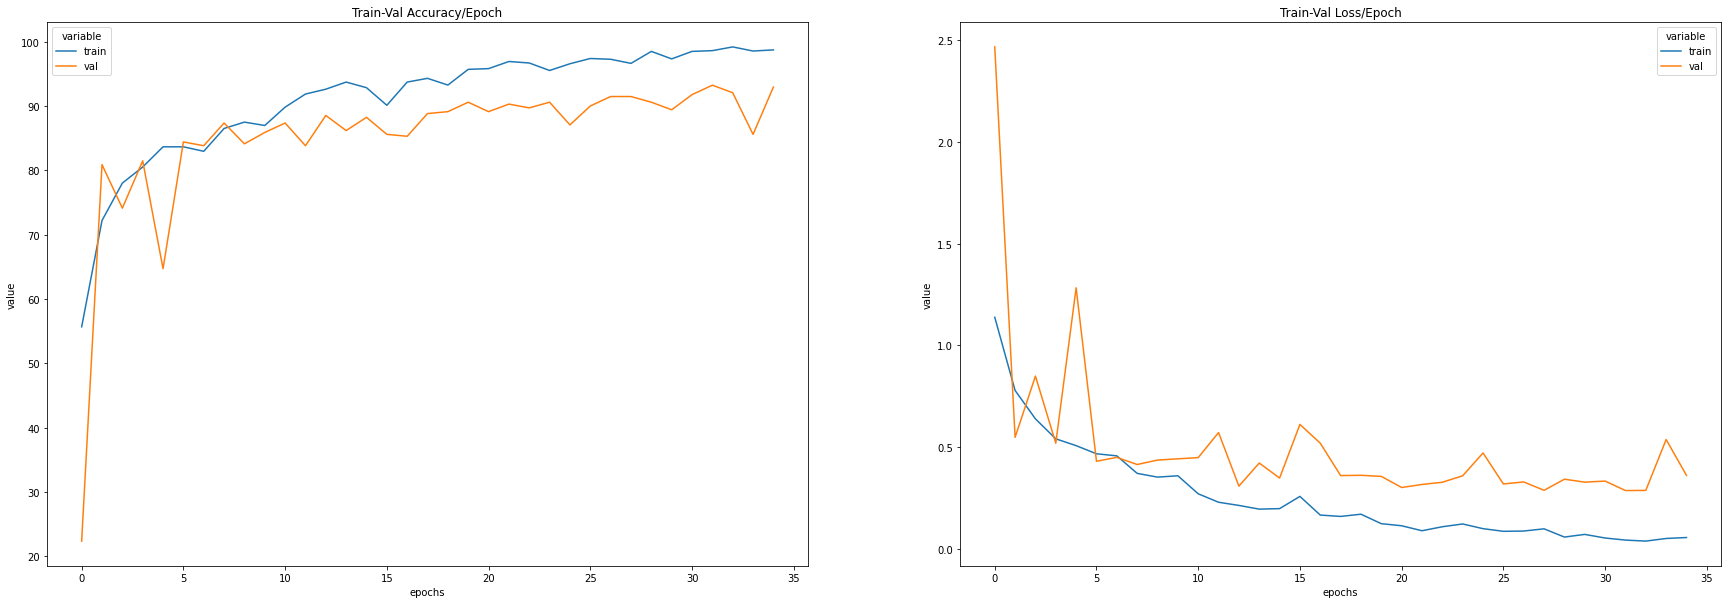

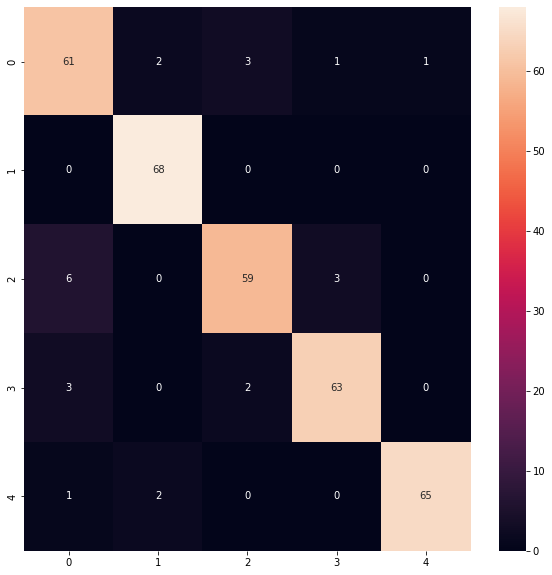

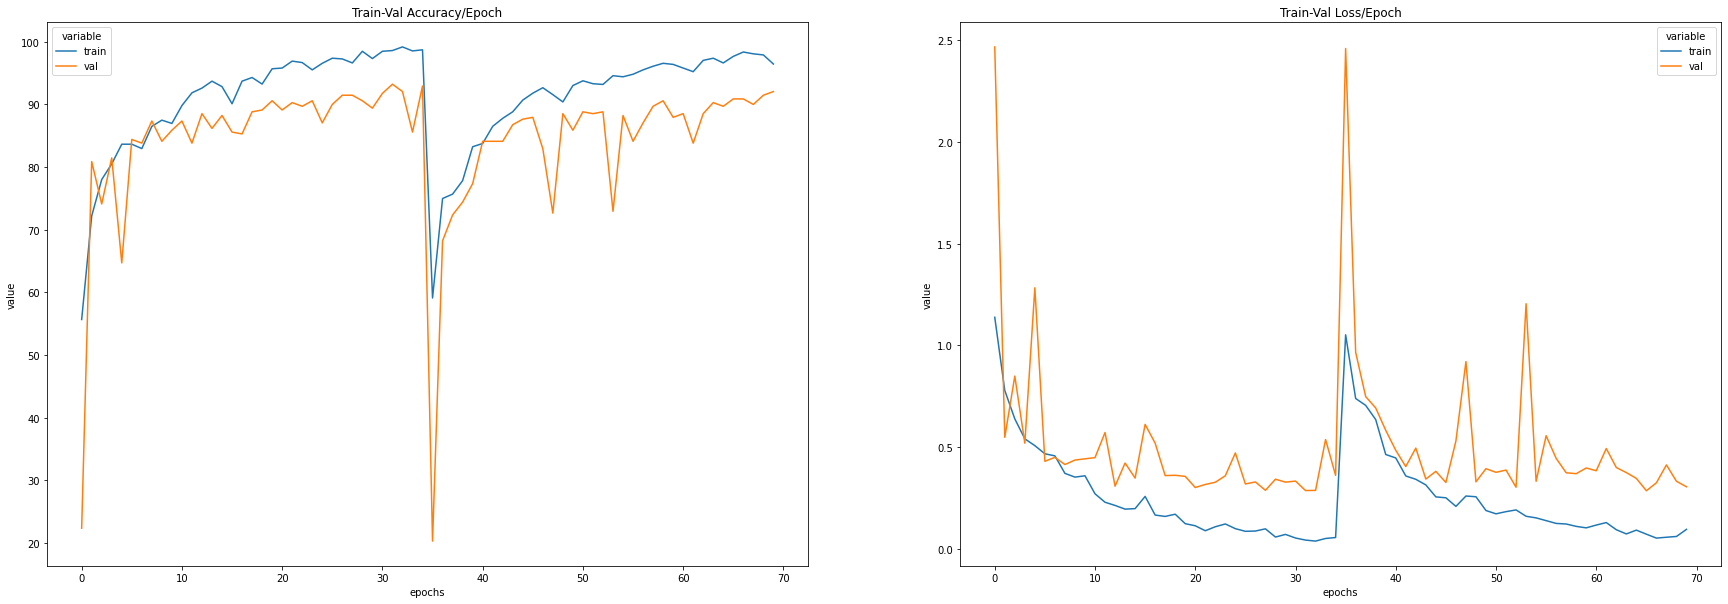

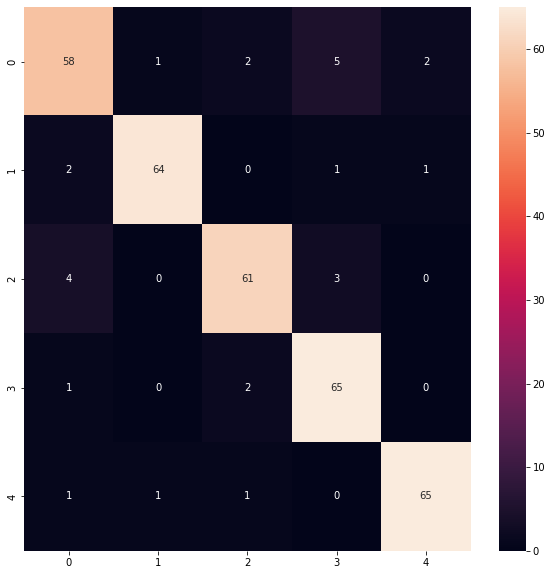

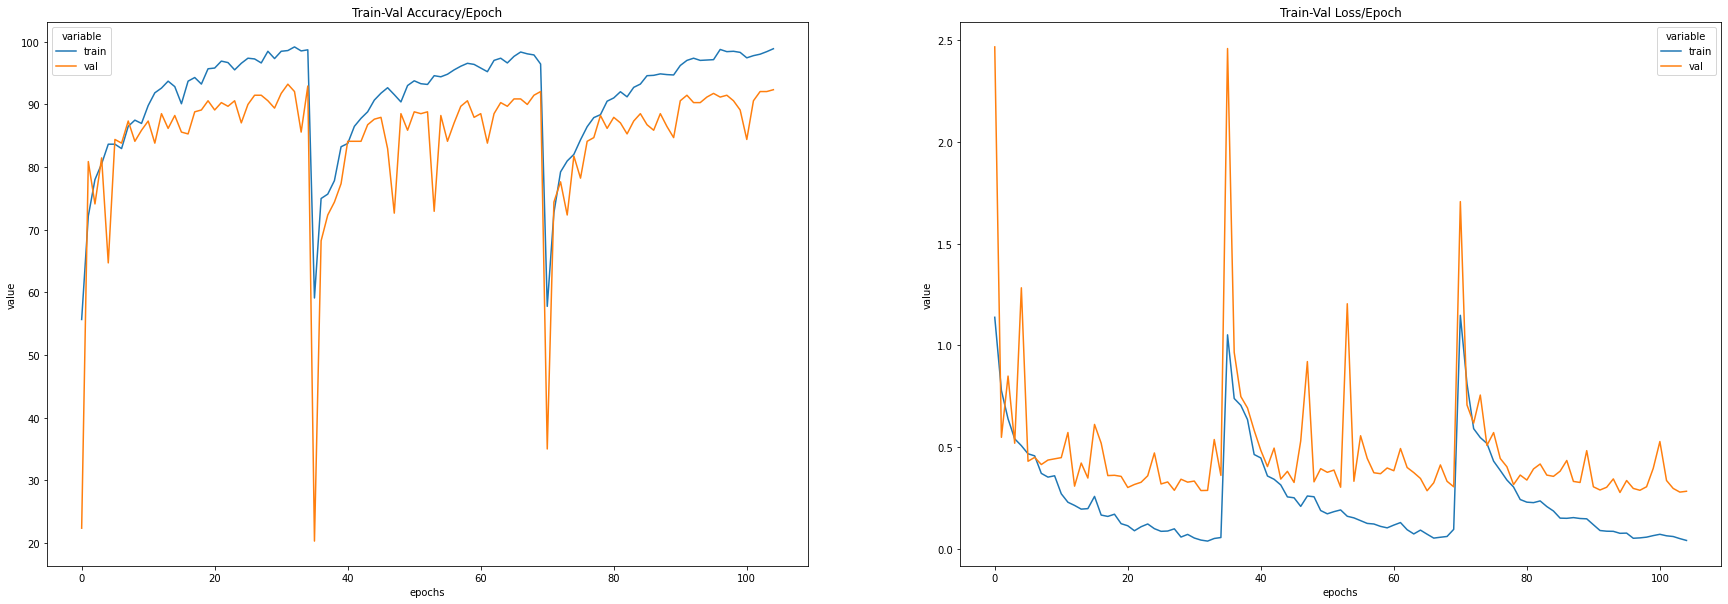

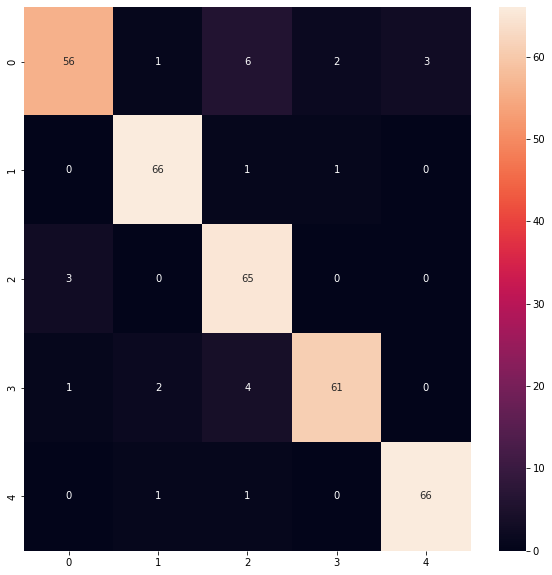

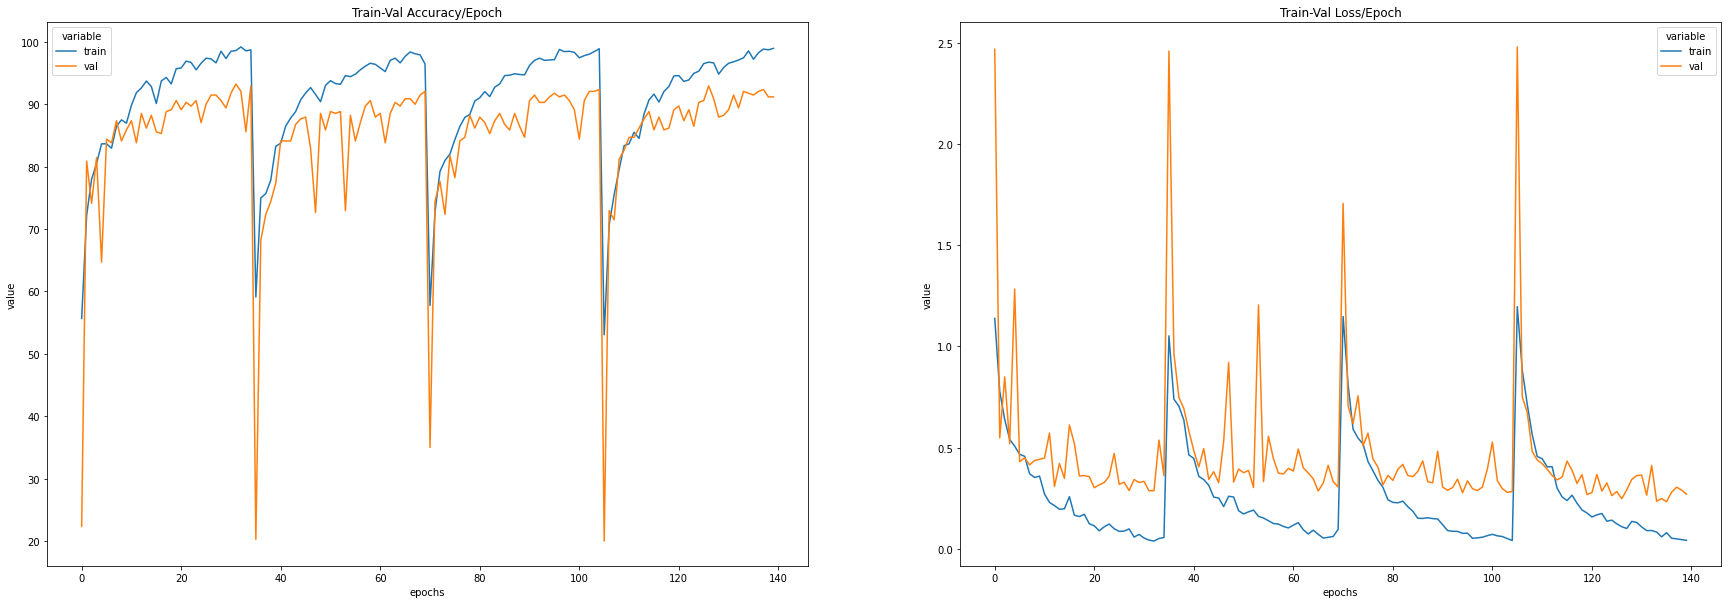

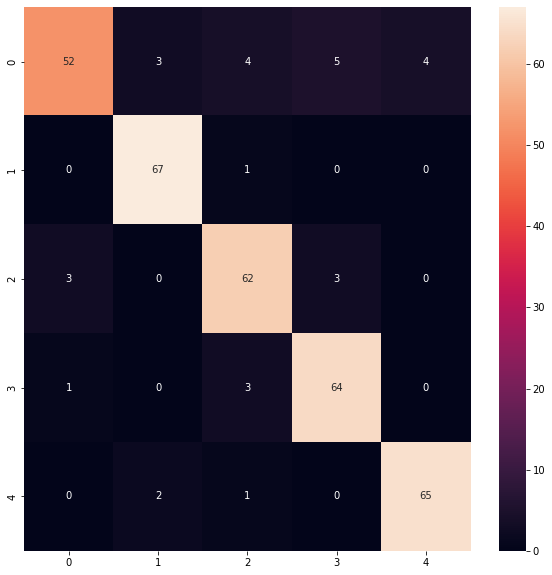

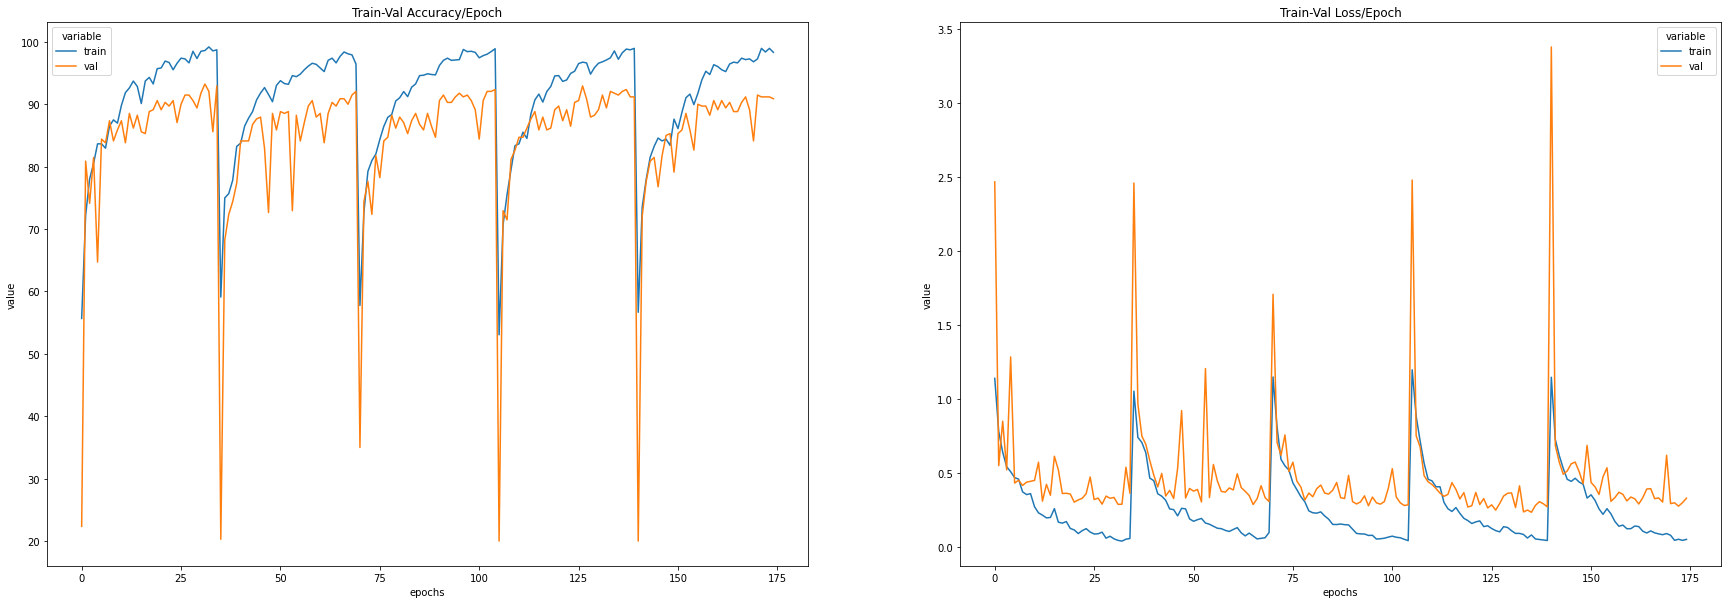

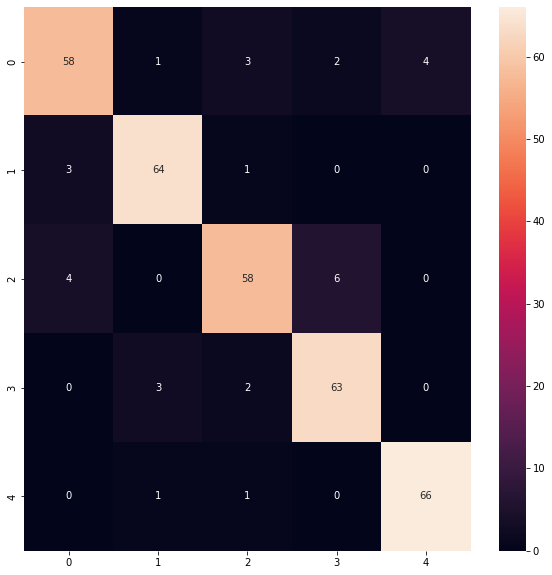

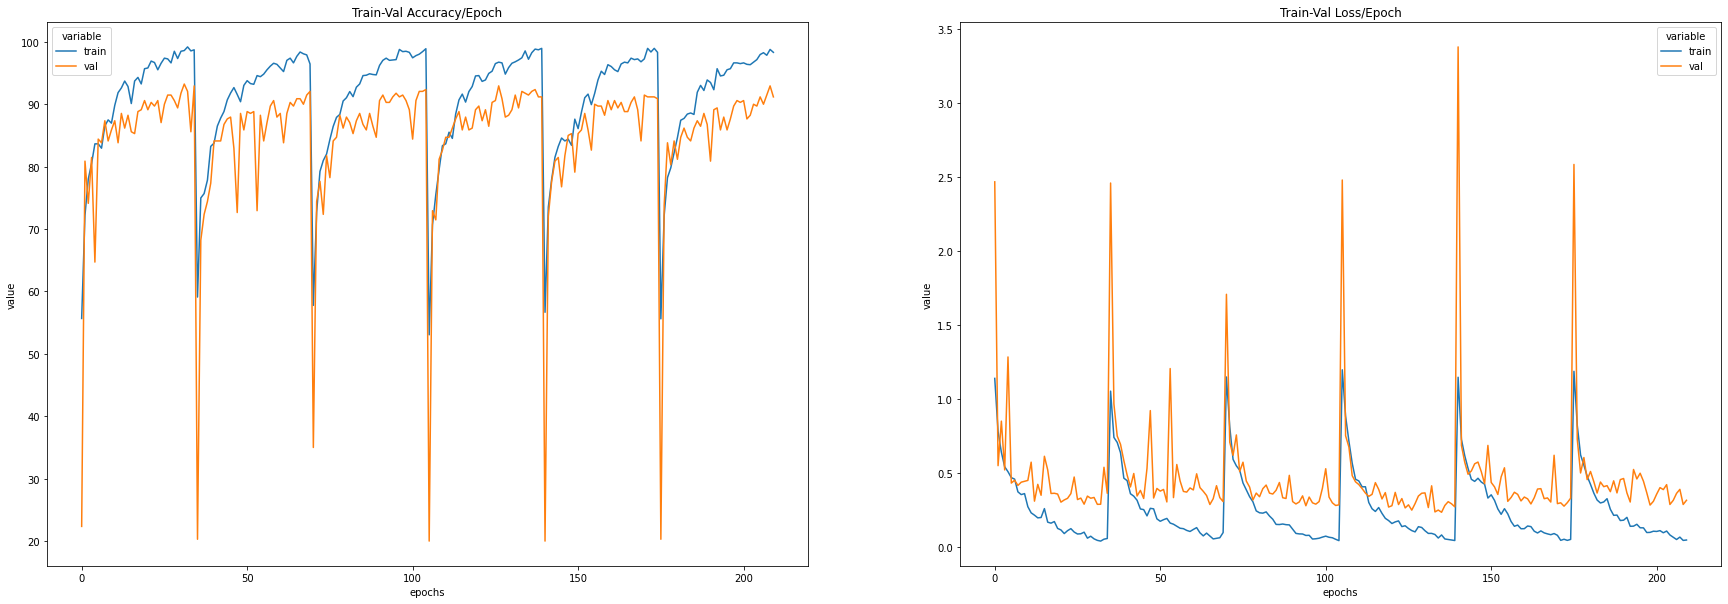

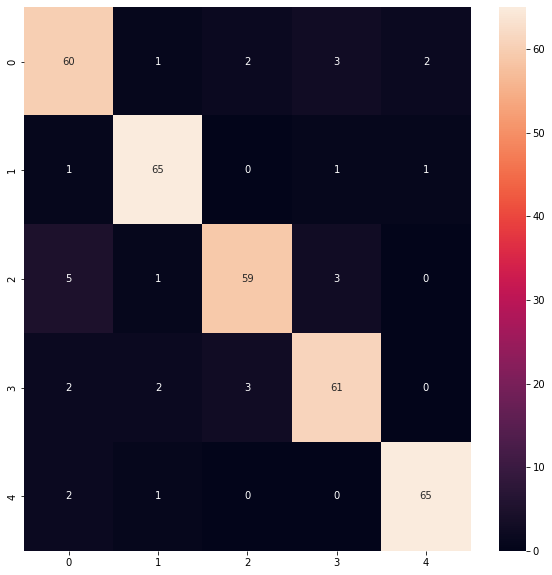

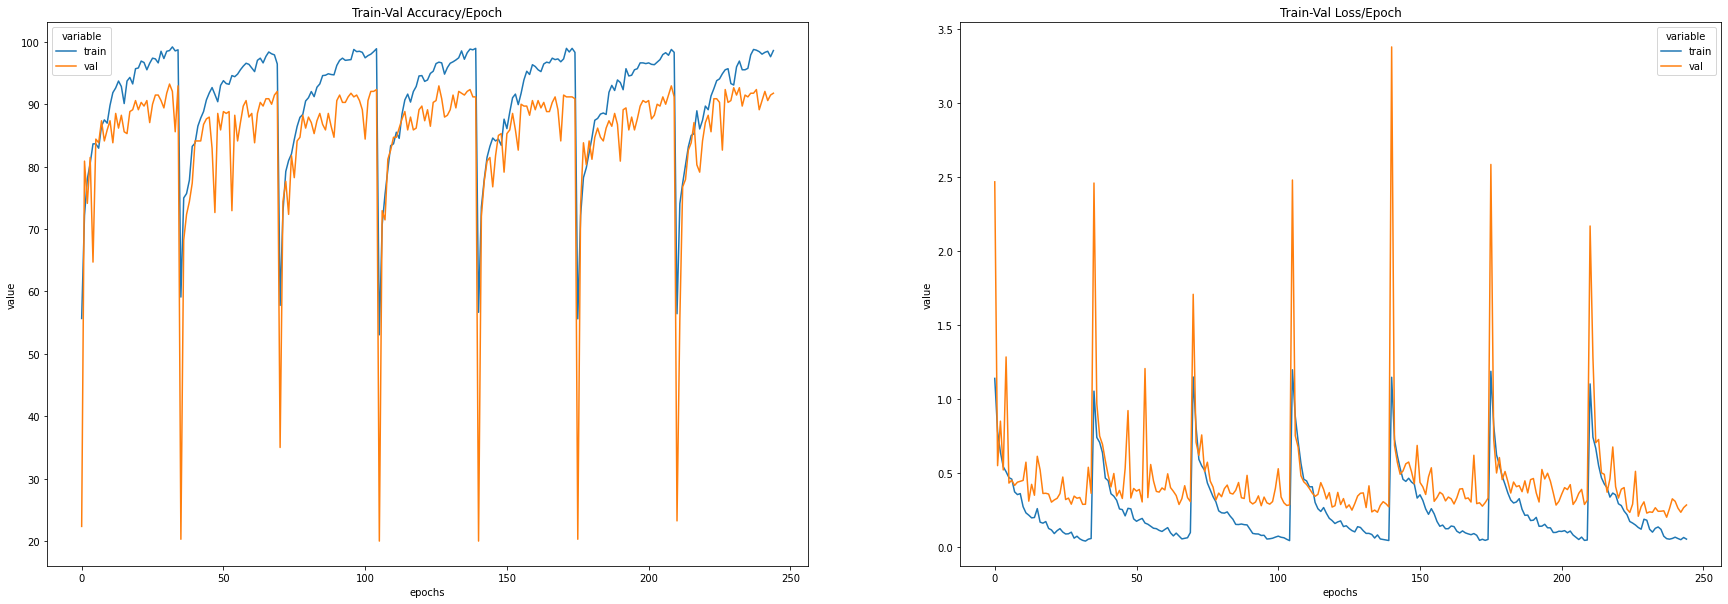

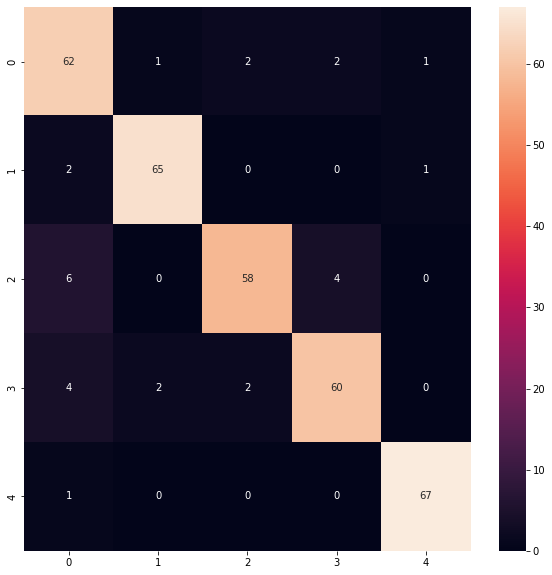

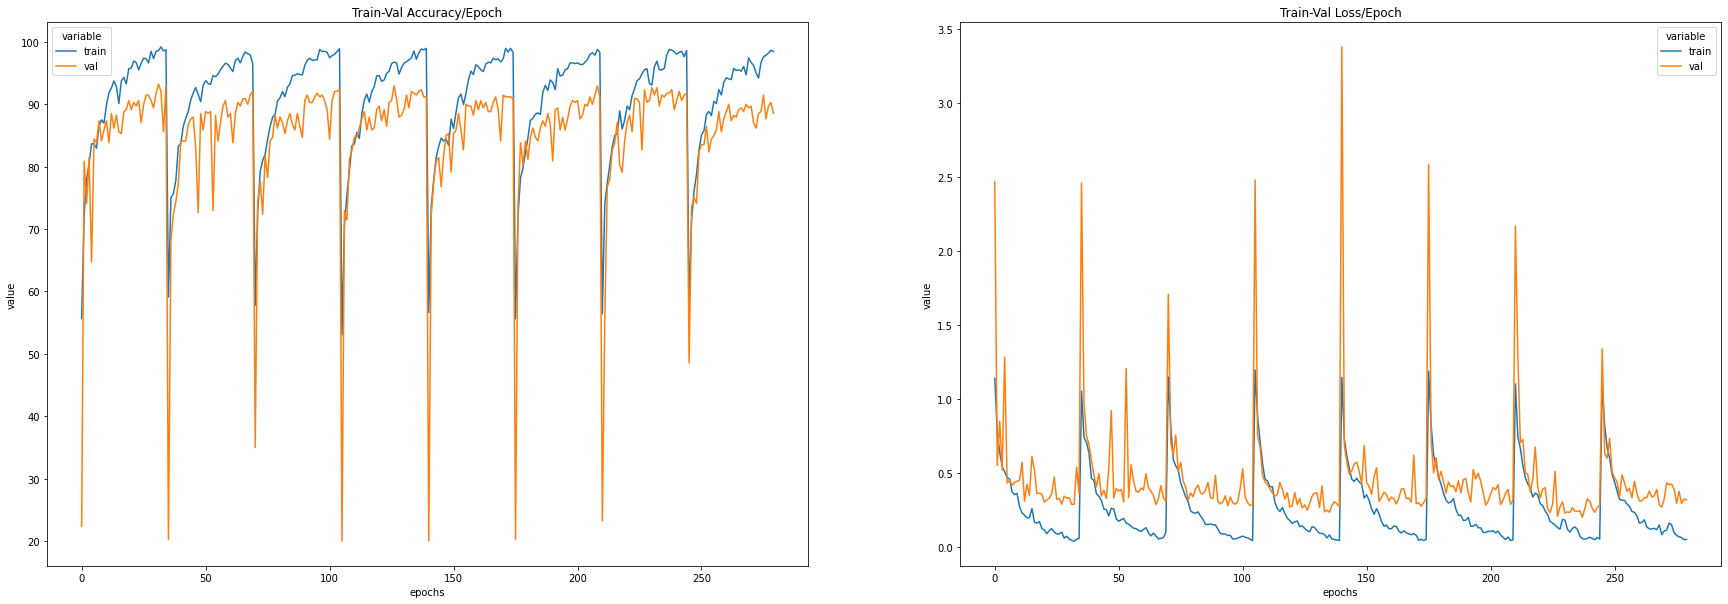

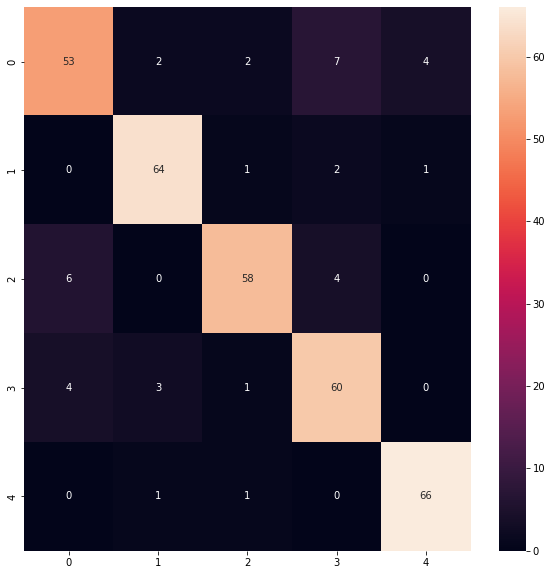

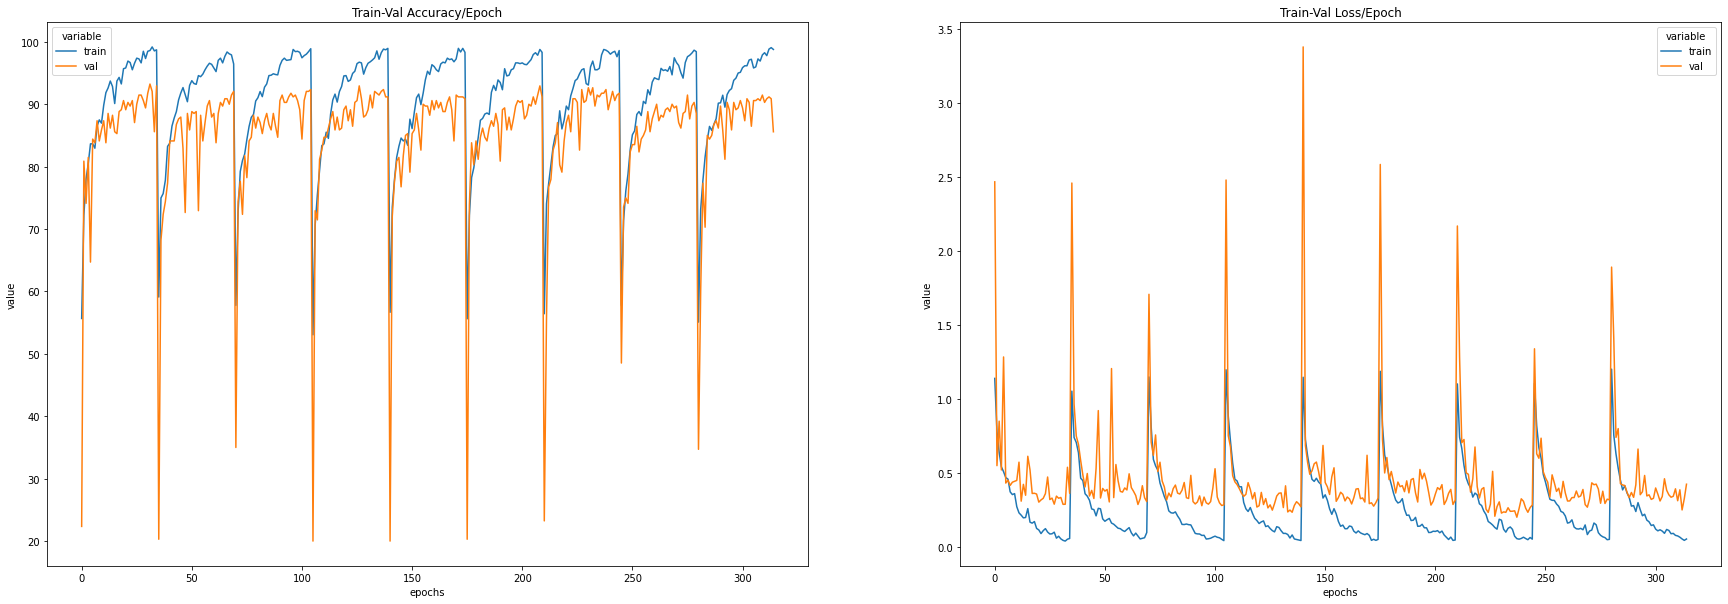

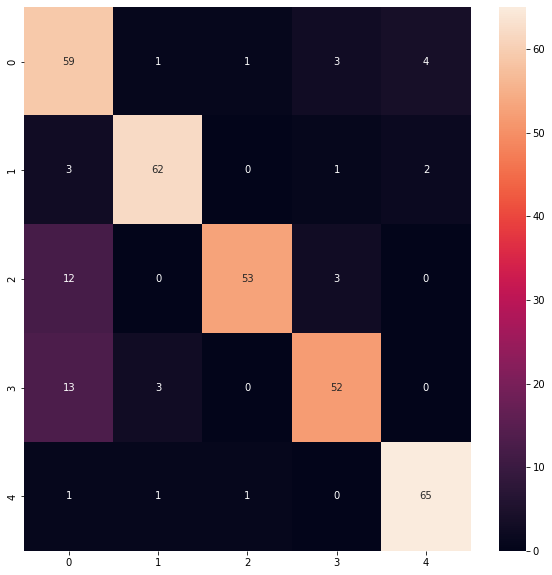

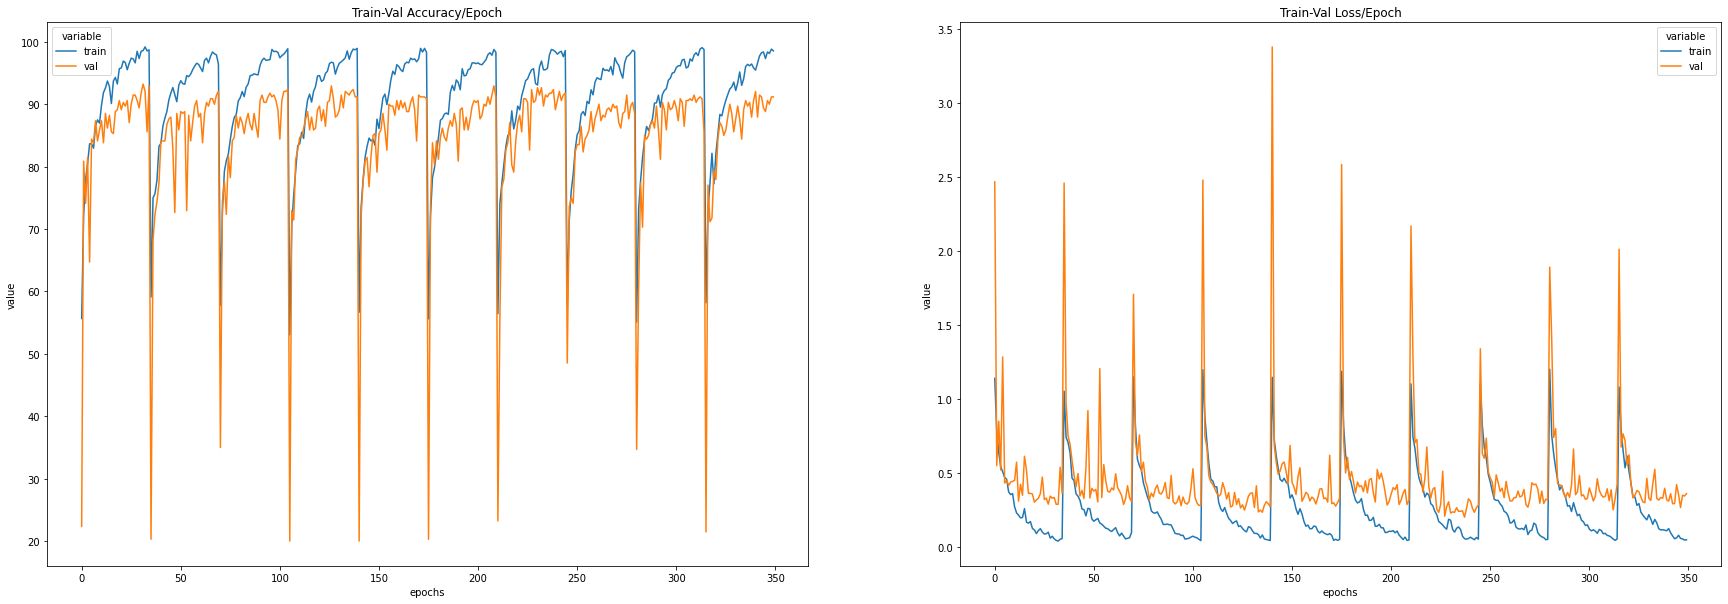

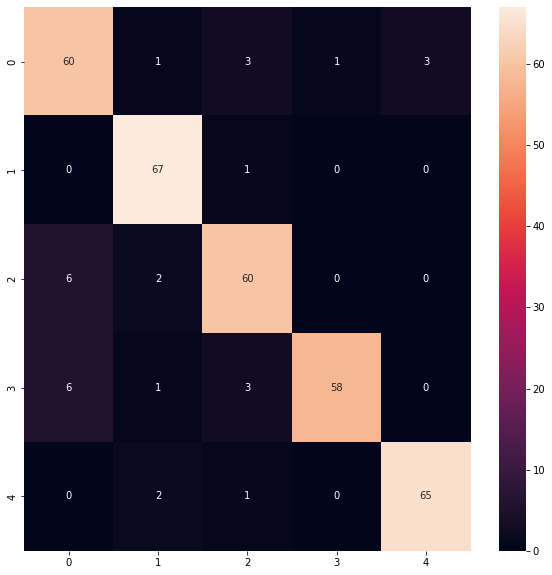

In [13]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    
    
    print('Fold {}'.format(fold + 1))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valloader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = ResNet18()
    num_class = len(classes)

    model.linear = nn.Linear(in_features = 8192, out_features = num_class)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    num_epoch = 1

    for epoch in range(num_epoch):
        best_accuracy = train(epoch, best_accuracy)

    loss_stats = {'train': train_losses, 'val': test_losses}
    accuracy_stats = {'train': train_accu, 'val': test_accu}

    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

    # Plot line charts
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
    train_acc = sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    train_loss = sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

    fig = train_loss.get_figure()
    fig.savefig('/content/results/train_acc_fold{}.png'.format(fold), dpi=400)

    fig = train_acc.get_figure()
    fig.savefig('/content/results/train_loss_fold{}.png'.format(fold), dpi=400)

    #train_acc.savefig('/content/results/train_acc_fold{}.png'.format(fold), dpi=400)
    #train_loss.savefig('/content/results/train_loss_fold{}.png'.format(fold), dpi=400)

    y_pred_list = []
    y_true_list = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm.tqdm(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_test_pred = model(x_batch)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())

    y_pred_final = []
    y_true_final = []
    for i in y_pred_list:
        y_pred_final = y_pred_final + list(i)

    for i in y_true_list:
        y_true_final = y_true_final + list(i)

    print(classification_report(y_true_final, y_pred_final))
    
    plt.figure(figsize = (10,10))
    cm_mat = sns.heatmap(confusion_matrix(y_true_final, y_pred_final), annot=True)
    fig = cm_mat.get_figure()
    fig.savefig('/content/results/cm_fold{}.png'.format(fold), dpi=400)

In [15]:
!zip -r main_cross_val.zip /content/results

updating: content/results/ (stored 0%)
  adding: content/results/train_loss_fold8.png (deflated 14%)
  adding: content/results/train_loss_fold0.png (deflated 30%)
  adding: content/results/train_loss_fold1.png (deflated 23%)
  adding: content/results/train_acc_fold6.png (deflated 15%)
  adding: content/results/cm_fold6.png (deflated 51%)
  adding: content/results/train_loss_fold6.png (deflated 15%)
  adding: content/results/cm_fold8.png (deflated 50%)
  adding: content/results/train_acc_fold2.png (deflated 20%)
  adding: content/results/train_loss_fold4.png (deflated 17%)
  adding: content/results/train_loss_fold3.png (deflated 17%)
  adding: content/results/train_loss_fold9.png (deflated 13%)
  adding: content/results/train_loss_fold7.png (deflated 14%)
  adding: content/results/train_acc_fold3.png (deflated 17%)
  adding: content/results/cm_fold5.png (deflated 51%)
  adding: content/results/train_acc_fold1.png (deflated 23%)
  adding: content/results/train_acc_fold5.png (deflated 16%

In [17]:
!mkdir /content/drive/MyDrive/assignment2_bias

In [18]:
!cp /content/main_cross_val.zip /content/drive/MyDrive/assignment2_bias

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fig = train_acc.get_figure()
fig.savefig('/content/results/train_acc_fold{}.png'.format(fold), dpi=400)


Device:: cuda:0



Epoch : 0


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 1.589 | Accuracy: 57.612
Train Loss: 1.296 | Accuracy: 56.444 | Val_accuracy: 57.612 | Val_loss: 1.589

Epoch : 1


100%|██████████| 11/11 [00:01<00:00, 10.13it/s]


Test Loss: 1.727 | Accuracy: 60.896
Train Loss: 0.970 | Accuracy: 71.429 | Val_accuracy: 60.896 | Val_loss: 1.727

Epoch : 2


100%|██████████| 11/11 [00:01<00:00, 10.12it/s]


Test Loss: 0.679 | Accuracy: 80.000
Train Loss: 0.845 | Accuracy: 73.778 | Val_accuracy: 80.000 | Val_loss: 0.679

Epoch : 3


100%|██████████| 11/11 [00:01<00:00, 10.09it/s]


Test Loss: 0.509 | Accuracy: 83.284
Train Loss: 0.648 | Accuracy: 77.968 | Val_accuracy: 83.284 | Val_loss: 0.509

Epoch : 4


100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


Test Loss: 0.510 | Accuracy: 82.985
Train Loss: 0.601 | Accuracy: 80.000 | Val_accuracy: 82.985 | Val_loss: 0.510

Epoch : 5


100%|██████████| 11/11 [00:01<00:00,  9.88it/s]


Test Loss: 0.369 | Accuracy: 85.373
Train Loss: 0.467 | Accuracy: 83.429 | Val_accuracy: 85.373 | Val_loss: 0.369

Epoch : 6


100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


Test Loss: 0.523 | Accuracy: 80.597
Train Loss: 0.432 | Accuracy: 84.254 | Val_accuracy: 80.597 | Val_loss: 0.523

Epoch : 7


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.566 | Accuracy: 78.507
Train Loss: 0.405 | Accuracy: 85.841 | Val_accuracy: 78.507 | Val_loss: 0.566

Epoch : 8


100%|██████████| 11/11 [00:01<00:00, 10.02it/s]


Test Loss: 0.314 | Accuracy: 88.955
Train Loss: 0.441 | Accuracy: 84.635 | Val_accuracy: 88.955 | Val_loss: 0.314

Epoch : 9


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.387 | Accuracy: 84.478
Train Loss: 0.321 | Accuracy: 89.714 | Val_accuracy: 84.478 | Val_loss: 0.387

Epoch : 10


100%|██████████| 11/11 [00:01<00:00,  9.98it/s]


Test Loss: 0.355 | Accuracy: 87.761
Train Loss: 0.301 | Accuracy: 89.651 | Val_accuracy: 87.761 | Val_loss: 0.355

Epoch : 11


100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


Test Loss: 0.358 | Accuracy: 86.866
Train Loss: 0.373 | Accuracy: 87.365 | Val_accuracy: 86.866 | Val_loss: 0.358

Epoch : 12


100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


Test Loss: 0.382 | Accuracy: 85.970
Train Loss: 0.322 | Accuracy: 88.254 | Val_accuracy: 85.970 | Val_loss: 0.382

Epoch : 13


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.296 | Accuracy: 88.657
Train Loss: 0.270 | Accuracy: 89.079 | Val_accuracy: 88.657 | Val_loss: 0.296

Epoch : 14


100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


Test Loss: 0.384 | Accuracy: 87.463
Train Loss: 0.286 | Accuracy: 90.159 | Val_accuracy: 87.463 | Val_loss: 0.384

Epoch : 15


100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


Test Loss: 0.297 | Accuracy: 88.955
Train Loss: 0.299 | Accuracy: 89.841 | Val_accuracy: 88.955 | Val_loss: 0.297

Epoch : 16


100%|██████████| 11/11 [00:01<00:00, 10.08it/s]


Test Loss: 0.218 | Accuracy: 92.537
Train Loss: 0.270 | Accuracy: 90.730 | Val_accuracy: 92.537 | Val_loss: 0.218

Epoch : 17


100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


Test Loss: 0.348 | Accuracy: 89.254
Train Loss: 0.202 | Accuracy: 92.698 | Val_accuracy: 89.254 | Val_loss: 0.348

Epoch : 18


100%|██████████| 11/11 [00:01<00:00,  9.93it/s]


Test Loss: 0.529 | Accuracy: 84.179
Train Loss: 0.265 | Accuracy: 91.111 | Val_accuracy: 84.179 | Val_loss: 0.529

Epoch : 19


100%|██████████| 11/11 [00:01<00:00,  9.96it/s]


Test Loss: 0.336 | Accuracy: 87.761
Train Loss: 0.221 | Accuracy: 92.698 | Val_accuracy: 87.761 | Val_loss: 0.336

Epoch : 20


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.303 | Accuracy: 88.657
Train Loss: 0.242 | Accuracy: 92.254 | Val_accuracy: 88.657 | Val_loss: 0.303

Epoch : 21


100%|██████████| 11/11 [00:01<00:00, 10.04it/s]


Test Loss: 0.405 | Accuracy: 86.269
Train Loss: 0.178 | Accuracy: 93.460 | Val_accuracy: 86.269 | Val_loss: 0.405

Epoch : 22


100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


Test Loss: 0.355 | Accuracy: 87.761
Train Loss: 0.215 | Accuracy: 92.698 | Val_accuracy: 87.761 | Val_loss: 0.355

Epoch : 23


100%|██████████| 11/11 [00:01<00:00, 10.09it/s]


Test Loss: 0.495 | Accuracy: 83.881
Train Loss: 0.148 | Accuracy: 94.476 | Val_accuracy: 83.881 | Val_loss: 0.495

Epoch : 24


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.352 | Accuracy: 88.657
Train Loss: 0.187 | Accuracy: 93.143 | Val_accuracy: 88.657 | Val_loss: 0.352

Epoch : 25


100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


Test Loss: 0.503 | Accuracy: 85.373
Train Loss: 0.194 | Accuracy: 93.270 | Val_accuracy: 85.373 | Val_loss: 0.503

Epoch : 26


100%|██████████| 11/11 [00:01<00:00,  9.86it/s]


Test Loss: 0.336 | Accuracy: 89.851
Train Loss: 0.187 | Accuracy: 93.905 | Val_accuracy: 89.851 | Val_loss: 0.336

Epoch : 27


100%|██████████| 11/11 [00:01<00:00, 10.07it/s]


Test Loss: 0.232 | Accuracy: 90.746
Train Loss: 0.128 | Accuracy: 96.000 | Val_accuracy: 90.746 | Val_loss: 0.232

Epoch : 28


100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


Test Loss: 0.213 | Accuracy: 92.836
Train Loss: 0.116 | Accuracy: 95.619 | Val_accuracy: 92.836 | Val_loss: 0.213

Epoch : 29


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.346 | Accuracy: 88.657
Train Loss: 0.102 | Accuracy: 96.889 | Val_accuracy: 88.657 | Val_loss: 0.346

Epoch : 30


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.205 | Accuracy: 93.134
Train Loss: 0.124 | Accuracy: 96.254 | Val_accuracy: 93.134 | Val_loss: 0.205

Epoch : 31


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.297 | Accuracy: 89.851
Train Loss: 0.106 | Accuracy: 96.762 | Val_accuracy: 89.851 | Val_loss: 0.297

Epoch : 32


100%|██████████| 11/11 [00:01<00:00,  9.96it/s]


Test Loss: 0.302 | Accuracy: 91.045
Train Loss: 0.106 | Accuracy: 96.000 | Val_accuracy: 91.045 | Val_loss: 0.302

Epoch : 33


100%|██████████| 11/11 [00:01<00:00, 10.05it/s]


Test Loss: 0.274 | Accuracy: 91.343
Train Loss: 0.107 | Accuracy: 96.698 | Val_accuracy: 91.343 | Val_loss: 0.274

Epoch : 34


100%|██████████| 11/11 [00:01<00:00,  9.95it/s]


Test Loss: 0.266 | Accuracy: 90.746
Train Loss: 0.074 | Accuracy: 97.714 | Val_accuracy: 90.746 | Val_loss: 0.266

Epoch : 35


100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


Test Loss: 0.459 | Accuracy: 89.552
Train Loss: 0.056 | Accuracy: 97.968 | Val_accuracy: 89.552 | Val_loss: 0.459

Epoch : 36


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.221 | Accuracy: 93.433
Train Loss: 0.055 | Accuracy: 97.968 | Val_accuracy: 93.433 | Val_loss: 0.221

Epoch : 37


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.232 | Accuracy: 92.836
Train Loss: 0.059 | Accuracy: 98.476 | Val_accuracy: 92.836 | Val_loss: 0.232

Epoch : 38


100%|██████████| 11/11 [00:01<00:00, 10.12it/s]


Test Loss: 0.239 | Accuracy: 91.642
Train Loss: 0.071 | Accuracy: 97.778 | Val_accuracy: 91.642 | Val_loss: 0.239

Epoch : 39


100%|██████████| 11/11 [00:01<00:00, 10.10it/s]


Test Loss: 0.217 | Accuracy: 94.030
Train Loss: 0.044 | Accuracy: 98.540 | Val_accuracy: 94.030 | Val_loss: 0.217

Epoch : 40


100%|██████████| 11/11 [00:01<00:00, 10.02it/s]


Test Loss: 0.278 | Accuracy: 91.045
Train Loss: 0.039 | Accuracy: 99.175 | Val_accuracy: 91.045 | Val_loss: 0.278

Epoch : 41


100%|██████████| 11/11 [00:01<00:00,  9.91it/s]


Test Loss: 0.268 | Accuracy: 93.433
Train Loss: 0.083 | Accuracy: 97.270 | Val_accuracy: 93.433 | Val_loss: 0.268

Epoch : 42


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.215 | Accuracy: 92.836
Train Loss: 0.055 | Accuracy: 98.730 | Val_accuracy: 92.836 | Val_loss: 0.215

Epoch : 43


100%|██████████| 11/11 [00:01<00:00, 10.07it/s]


Test Loss: 0.367 | Accuracy: 88.657
Train Loss: 0.084 | Accuracy: 97.016 | Val_accuracy: 88.657 | Val_loss: 0.367

Epoch : 44


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


Test Loss: 0.260 | Accuracy: 94.627
Train Loss: 0.066 | Accuracy: 98.286 | Val_accuracy: 94.627 | Val_loss: 0.260

Epoch : 45


100%|██████████| 11/11 [00:01<00:00, 10.00it/s]


Test Loss: 0.302 | Accuracy: 91.343
Train Loss: 0.117 | Accuracy: 96.762 | Val_accuracy: 91.343 | Val_loss: 0.302

Epoch : 46


100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


Test Loss: 0.279 | Accuracy: 91.343
Train Loss: 0.059 | Accuracy: 98.159 | Val_accuracy: 91.343 | Val_loss: 0.279

Epoch : 47


100%|██████████| 11/11 [00:01<00:00,  9.95it/s]


Test Loss: 0.223 | Accuracy: 92.537
Train Loss: 0.082 | Accuracy: 97.460 | Val_accuracy: 92.537 | Val_loss: 0.223

Epoch : 48


100%|██████████| 11/11 [00:01<00:00,  9.99it/s]


Test Loss: 0.259 | Accuracy: 91.642
Train Loss: 0.065 | Accuracy: 98.794 | Val_accuracy: 91.642 | Val_loss: 0.259

Epoch : 49


100%|██████████| 11/11 [00:01<00:00, 10.00it/s]

Test Loss: 0.281 | Accuracy: 93.731
Train Loss: 0.076 | Accuracy: 97.270 | Val_accuracy: 93.731 | Val_loss: 0.281


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

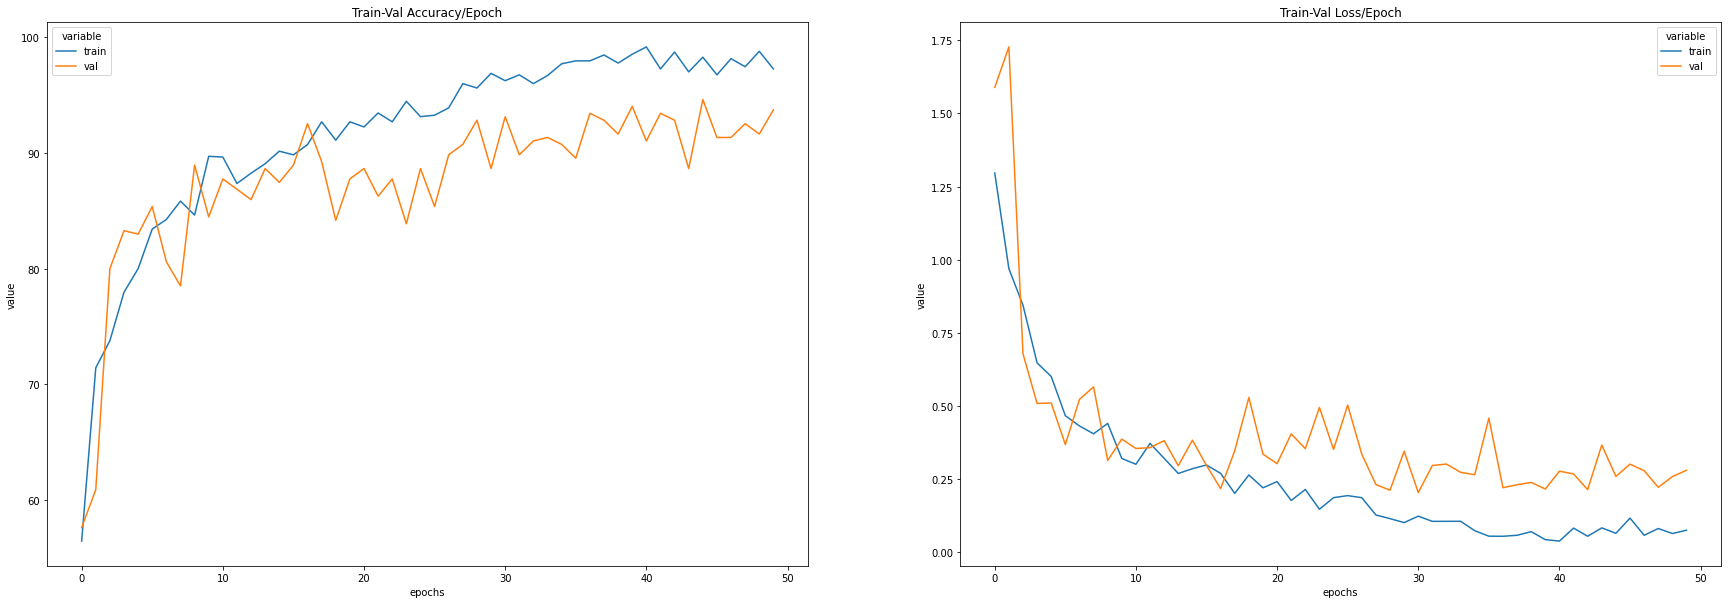

  0%|          | 0/11 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        67
           1       0.96      0.99      0.97        67
           2       0.97      0.85      0.90        67
           3       0.86      0.99      0.92        67
           4       1.00      0.97      0.98        67

    accuracy                           0.94       335
   macro avg       0.94      0.94      0.94       335
weighted avg       0.94      0.94      0.94       335



In [ ]:
print(confusion_matrix(y_true_final, y_pred_final))

[[60  0  2  5  0]
 [ 0 66  0  1  0]
 [ 4  1 57  5  0]
 [ 1  0  0 66  0]
 [ 0  2  0  0 65]]


In [ ]:
torch.save(model.state_dict(), 'main_model.pth')


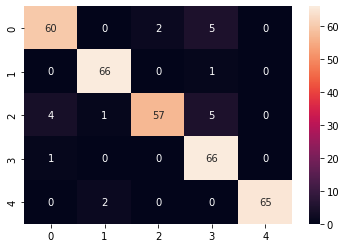